In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from jcopml.time_series.decomposition import stl_decomposition
from jcopml.time_series import auto_ets

from pmdarima import auto_arima

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data 

In [2]:
df = pd.read_csv("electricity_data_US_only.csv", index_col="Date", parse_dates=["Date"])
df.head()

,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial
Date,,,,,
2001-01-01,332493,236467,82269,629,13128
2001-02-01,282940,199802,71169,548,11421
2001-03-01,300707,211942,75758,553,12454
2001-04-01,278079,197499,68356,550,11674
2001-05-01,300492,215508,72658,575,11751


In [3]:
df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', length=255, freq=None)

# Exploratory Data Analysis 

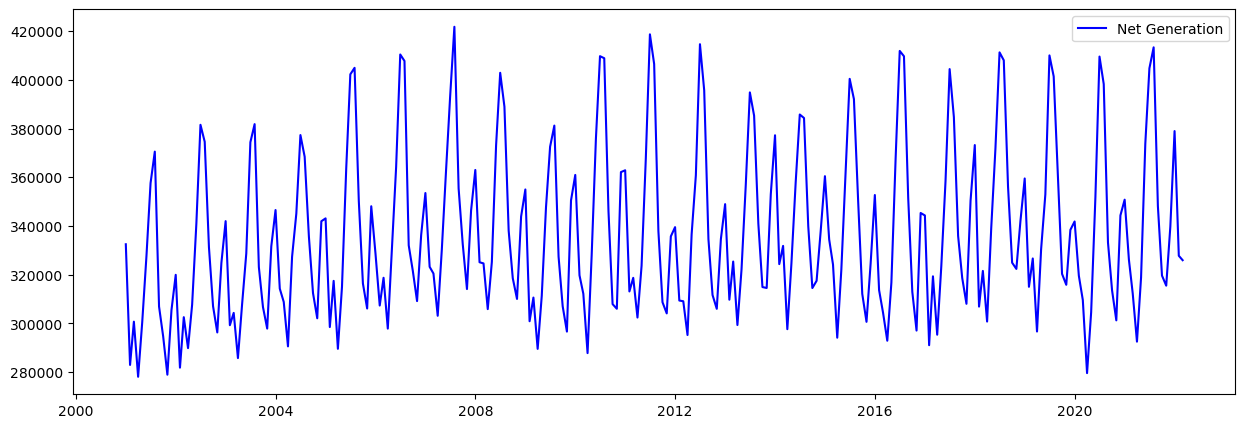

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['United States : all sectors'], 'b-', label='Net Generation')
plt.legend()

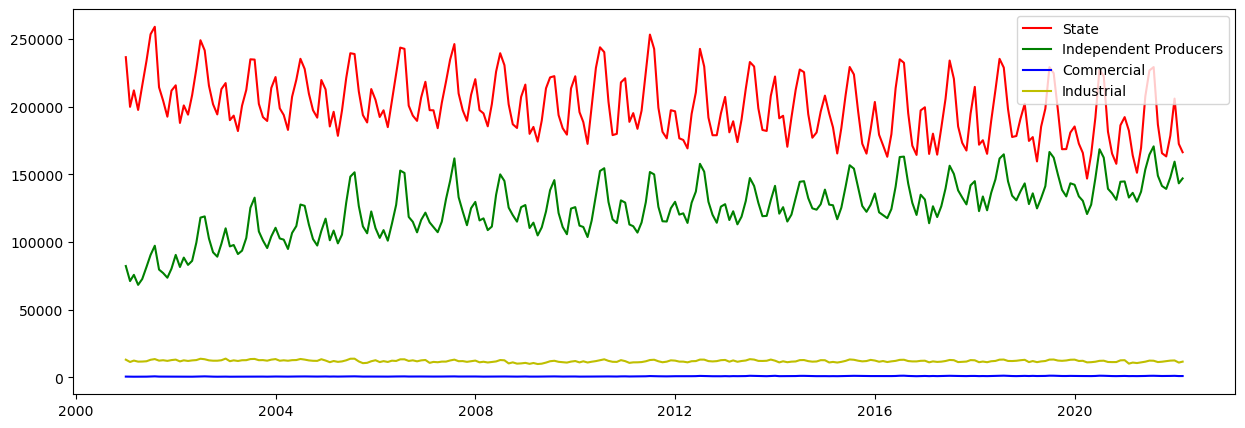

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['United States : electric utility'], 'r-', label='State')
plt.plot(df['United States : independent power producers'], 'g-', label='Independent Producers')
plt.plot(df['United States : all commercial'], 'b-', label='Commercial')
plt.plot(df['United States : all industrial'], 'y-', label='Industrial')
plt.legend()

# Feature Engineering 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2001-01-01 to 2022-03-01
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   United States : all sectors                  255 non-null    int64
 1   United States : electric utility             255 non-null    int64
 2   United States : independent power producers  255 non-null    int64
 3   United States : all commercial               255 non-null    int64
 4   United States : all industrial               255 non-null    int64
dtypes: int64(5)
memory usage: 12.0 KB


In [7]:
df['united_states_all_sectors'] = df['United States : all sectors']
df.drop(columns=['United States : electric utility', 'United States : independent power producers',
                 'United States : all commercial', 'United States : all industrial', 'United States : all sectors'], inplace=True)
df.head()

,united_states_all_sectors
Date,
2001-01-01,332493
2001-02-01,282940
2001-03-01,300707
2001-04-01,278079
2001-05-01,300492


# Forecasting 

<Axes: xlabel='Date'>

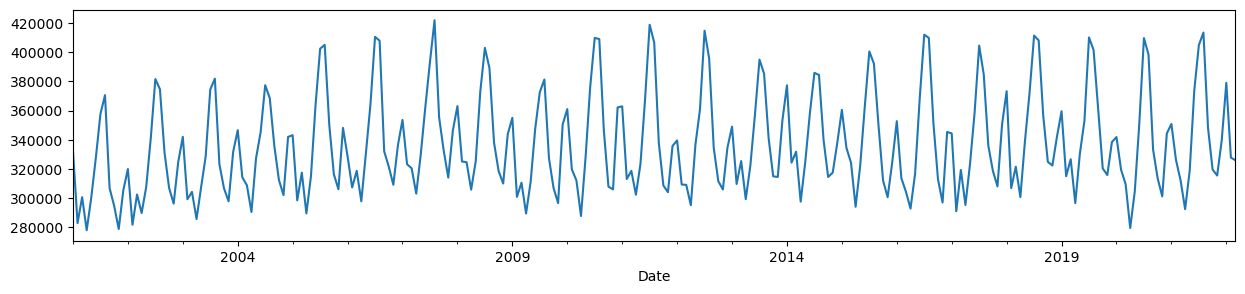

In [8]:
series = df.united_states_all_sectors
X_train, X_test = series[:-25], series[-25:]
series.plot(figsize=(15,3))

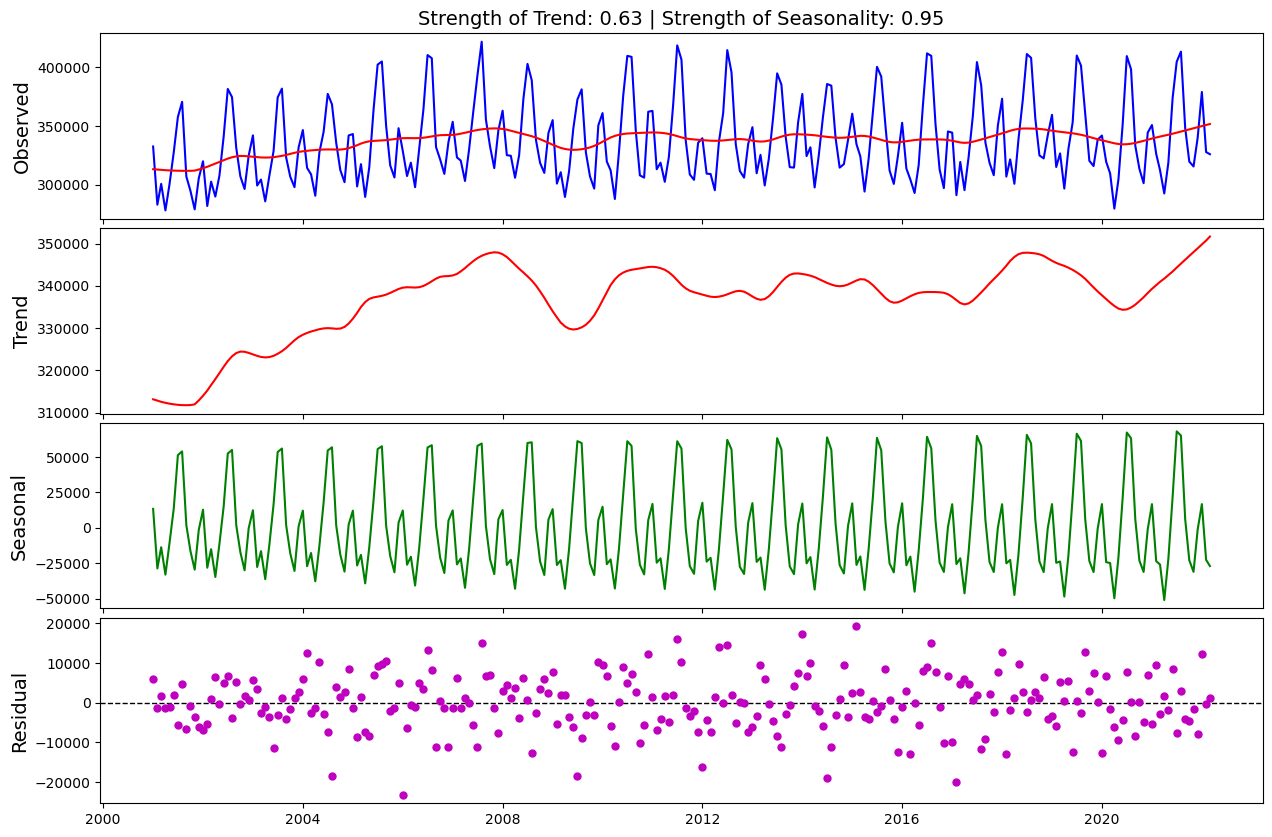

In [9]:
stl_decomposition(df.united_states_all_sectors, plot=True)

## With ARIMA

In [10]:
arima = auto_arima(X_train, seasonal=True, m=4, information_criterion='aicc', trace=True, suppress_warnings=True, random_state=42)

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AICC=inf, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AICC=5395.604, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AICC=5383.795, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AICC=5376.251, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AICC=5393.572, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AICC=5394.963, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AICC=5373.308, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AICC=5383.805, Time=0.05 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AICC=5294.802, Time=0.16 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : AICC=5339.347, Time=0.11 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : AICC=5252.037, Time=0.75 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AICC=5337.492, Time=0.23 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AICC=5253.359, Time=0.45 sec
 ARIMA(1,1,1)(2,0,2)[4] intercept   : AICC=5238.150, Time=1.17 sec
 ARIMA(1,1,1)(1,0,2)[4]

In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  230
Model:             SARIMAX(3, 1, 0)x(2, 0, [1, 2], 4)   Log Likelihood               -2585.951
Date:                                Fri, 13 Oct 2023   AIC                           5187.902
Time:                                        20:28:33   BIC                           5215.372
Sample:                                             0   HQIC                          5198.984
                                                - 230                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1602      0.124     -1.288      0.198      -0.404       0.084
ar.L2         -0.1281      0.074     -1.726      0.084      -0.274       0.017
ar.L3         -0.1746      0.080     -2.172      0.030      -0.332      -0.017
ar.S.L4       -0.9764      0.027    -36.810      0.000      -1.028      -0.924
ar.S.L8       -0.9857      0.024    -40.288      0.000      -1.034      -0.938
ma.S.L4        0.9435      0.075     12.663      0.000       0.797       1.090
ma.S.L8        0.9102      0.080     11.335      0.000       0.753       1.068
sigma2      6.438e+08   1.56e-11   4.14e+19      0.000    6.44e+08    6.44e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.93   Prob(JB):                         0.95
Heteroskedasticity (H):               0.44   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+36. Standard errors may be unstable.
"""

In [12]:
n_forecast = len(X_test)+20
pred = arima.predict(n_forecast)

dates = pd.date_range(X_train.index[-1], periods=n_forecast, freq='M')
pred = pd.Series(pred, index=dates)

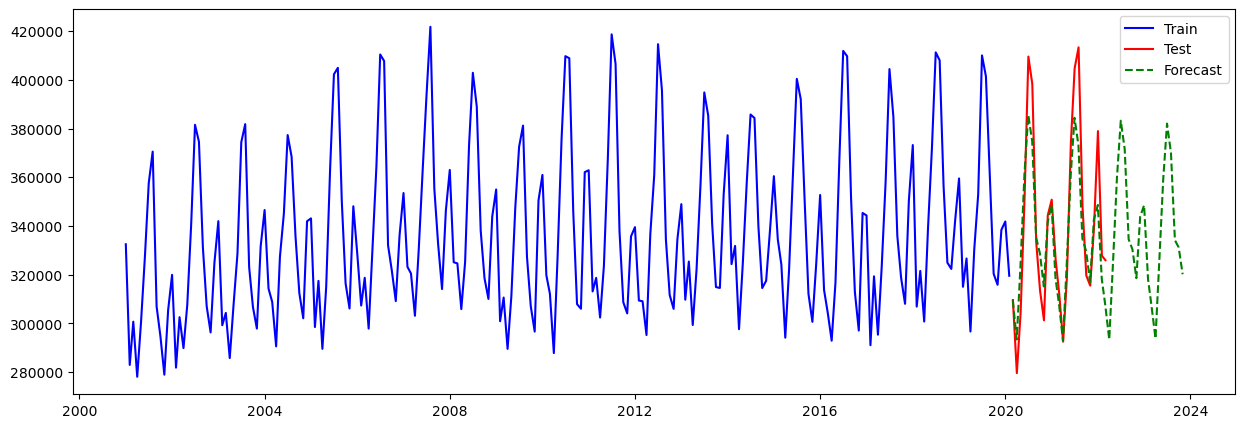

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(X_train, 'b-', label='Train')
plt.plot(X_test, 'r-', label='Test')
plt.plot(pred, 'g--', label='Forecast')
plt.legend()

# With LSTM 

In [14]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import normaltest

In [15]:
normaltest(df.united_states_all_sectors)

NormaltestResult(statistic=19.12835404369296, pvalue=7.019896280870144e-05)

In [16]:
values = df.united_states_all_sectors.values
values = values.reshape(len(values), 1)

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(values)

In [18]:
df.united_states_all_sectors = scaler.transform(values)
df.united_states_all_sectors

Date
2001-01-01   -0.125149
2001-02-01   -1.573316
2001-03-01   -1.054083
2001-04-01   -1.715377
2001-05-01   -1.060366
                ...   
2021-11-01   -0.621909
2021-12-01    0.085005
2022-01-01    1.233035
2022-02-01   -0.263265
2022-03-01   -0.316307
Name: united_states_all_sectors, Length: 255, dtype: float64

## Dataset Splitting 

In [19]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((204, 1), (51, 1))

## Dataset & Dataloader 

In [20]:
seq_len = 12
bs = 16

train_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (16, 12, 1)
Note: last 11 data excluded

(N, S, F): (4, 12, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [22]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 8,
    'num_layers': 2,
    'dropout': 0.001,
    'seq_len': train_set.n_seq
})

## Training Preparation 

In [23]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

## Training

In [24]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.9872 | Test_cost  = 1.1205 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.9866 | Test_cost  = 1.1191 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.9860 | Test_cost  = 1.1179 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.9854 | Test_cost  = 1.1166 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.9848 | Test_cost  = 1.1154 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.9842 | Test_cost  = 1.1142 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.9836 | Test_cost  = 1.1130 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.9830 | Test_cost  = 1.1118 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.9824 | Test_cost  = 1.1107 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.9818 | Test_cost  = 1.1096 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.9812 | Test_cost  = 1.1085 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.9807 | Test_cost  = 1.1075 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.9799 | Test_cost  = 1.1065 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.9794 | Test_cost  = 1.1055 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.9787 | Test_cost  = 1.1046 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.9782 | Test_cost  = 1.1036 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.9775 | Test_cost  = 1.1027 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.9768 | Test_cost  = 1.1019 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.9763 | Test_cost  = 1.1010 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.9756 | Test_cost  = 1.1002 | 


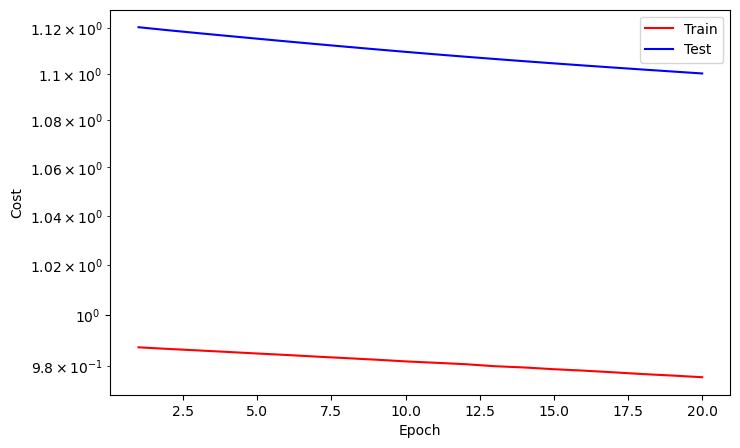

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.9749 | Test_cost  = 1.0993 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.9743 | Test_cost  = 1.0985 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.9736 | Test_cost  = 1.0976 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.9729 | Test_cost  = 1.0968 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.9722 | Test_cost  = 1.0959 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.9714 | Test_cost  = 1.0950 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.9708 | Test_cost  = 1.0941 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.9700 | Test_cost  = 1.0932 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.9693 | Test_cost  = 1.0923 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.9684 | Test_cost  = 1.0913 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.9677 | Test_cost  = 1.0903 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.9669 | Test_cost  = 1.0892 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.9661 | Test_cost  = 1.0881 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.9652 | Test_cost  = 1.0870 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.9643 | Test_cost  = 1.0858 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.9635 | Test_cost  = 1.0846 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.9626 | Test_cost  = 1.0834 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.9616 | Test_cost  = 1.0821 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.9608 | Test_cost  = 1.0807 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.9597 | Test_cost  = 1.0793 | 


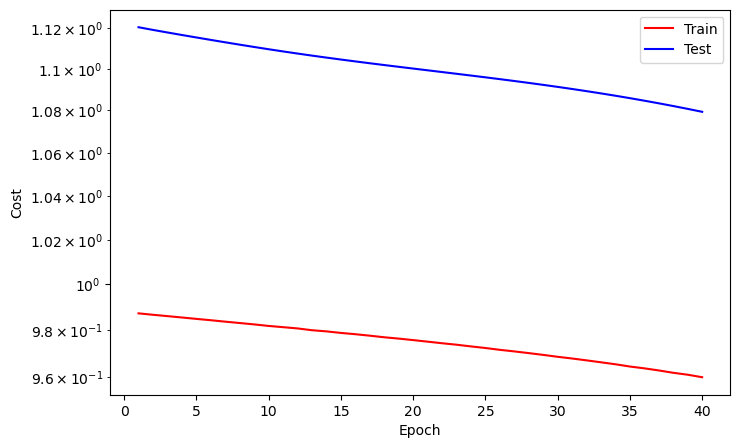

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.9588 | Test_cost  = 1.0778 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.9577 | Test_cost  = 1.0763 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.9565 | Test_cost  = 1.0748 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.9557 | Test_cost  = 1.0732 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.9547 | Test_cost  = 1.0716 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.9534 | Test_cost  = 1.0699 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.9523 | Test_cost  = 1.0681 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.9511 | Test_cost  = 1.0664 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.9500 | Test_cost  = 1.0646 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.9486 | Test_cost  = 1.0627 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.9472 | Test_cost  = 1.0608 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.9462 | Test_cost  = 1.0589 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.9447 | Test_cost  = 1.0569 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.9433 | Test_cost  = 1.0549 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.9419 | Test_cost  = 1.0529 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.9404 | Test_cost  = 1.0508 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.9389 | Test_cost  = 1.0487 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.9374 | Test_cost  = 1.0466 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.9358 | Test_cost  = 1.0444 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.9343 | Test_cost  = 1.0422 | 


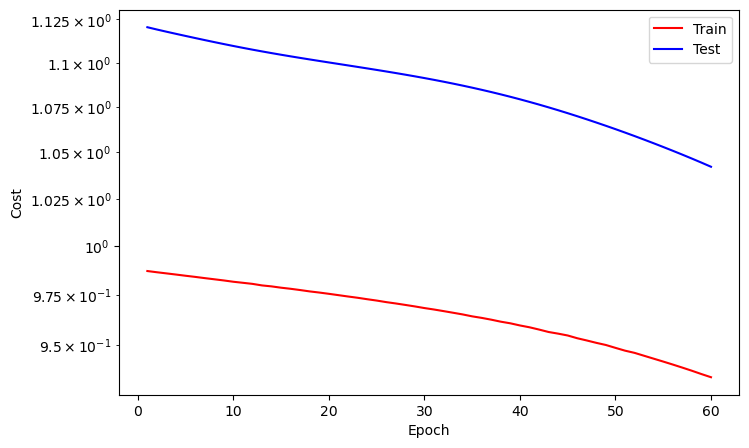

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.9326 | Test_cost  = 1.0399 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.9306 | Test_cost  = 1.0375 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.9291 | Test_cost  = 1.0351 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.9273 | Test_cost  = 1.0327 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.9255 | Test_cost  = 1.0302 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.9236 | Test_cost  = 1.0276 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.9217 | Test_cost  = 1.0250 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.9197 | Test_cost  = 1.0223 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.9178 | Test_cost  = 1.0196 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.9155 | Test_cost  = 1.0168 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.9131 | Test_cost  = 1.0139 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.9112 | Test_cost  = 1.0110 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.9090 | Test_cost  = 1.0079 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.9075 | Test_cost  = 1.0048 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.9043 | Test_cost  = 1.0017 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.9023 | Test_cost  = 0.9984 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.8994 | Test_cost  = 0.9951 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.8968 | Test_cost  = 0.9917 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.8943 | Test_cost  = 0.9882 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.8915 | Test_cost  = 0.9847 | 


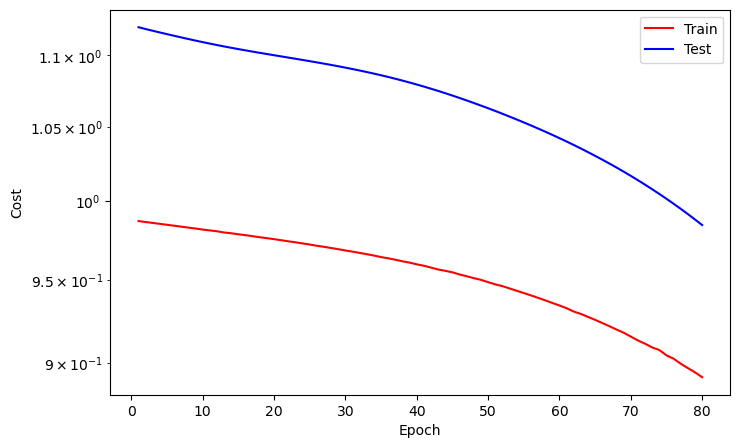

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.8887 | Test_cost  = 0.9810 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.8859 | Test_cost  = 0.9773 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.8829 | Test_cost  = 0.9734 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.8812 | Test_cost  = 0.9695 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.8774 | Test_cost  = 0.9655 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.8735 | Test_cost  = 0.9613 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.8703 | Test_cost  = 0.9571 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.8673 | Test_cost  = 0.9528 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.8639 | Test_cost  = 0.9484 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.8605 | Test_cost  = 0.9439 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.8569 | Test_cost  = 0.9394 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.8533 | Test_cost  = 0.9348 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.8497 | Test_cost  = 0.9301 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.8460 | Test_cost  = 0.9253 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.8420 | Test_cost  = 0.9205 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.8381 | Test_cost  = 0.9155 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.8344 | Test_cost  = 0.9105 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.8300 | Test_cost  = 0.9055 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.8258 | Test_cost  = 0.9003 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.8214 | Test_cost  = 0.8951 | 


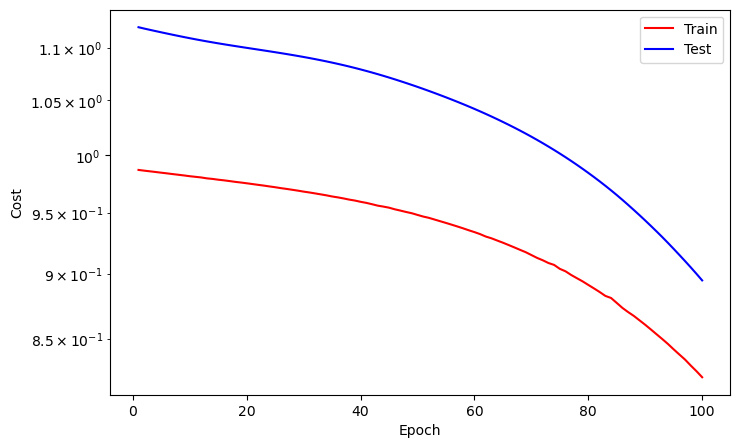

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.8172 | Test_cost  = 0.8898 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.8126 | Test_cost  = 0.8843 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.8083 | Test_cost  = 0.8788 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.8039 | Test_cost  = 0.8732 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.7986 | Test_cost  = 0.8676 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.7947 | Test_cost  = 0.8620 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.7893 | Test_cost  = 0.8563 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.7860 | Test_cost  = 0.8505 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.7789 | Test_cost  = 0.8447 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.7748 | Test_cost  = 0.8390 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.7693 | Test_cost  = 0.8335 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.7643 | Test_cost  = 0.8280 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.7602 | Test_cost  = 0.8226 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.7542 | Test_cost  = 0.8172 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 0.7476 | Test_cost  = 0.8117 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 0.7439 | Test_cost  = 0.8062 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 0.7374 | Test_cost  = 0.8007 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 0.7313 | Test_cost  = 0.7950 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.7245 | Test_cost  = 0.7893 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.7195 | Test_cost  = 0.7834 | 


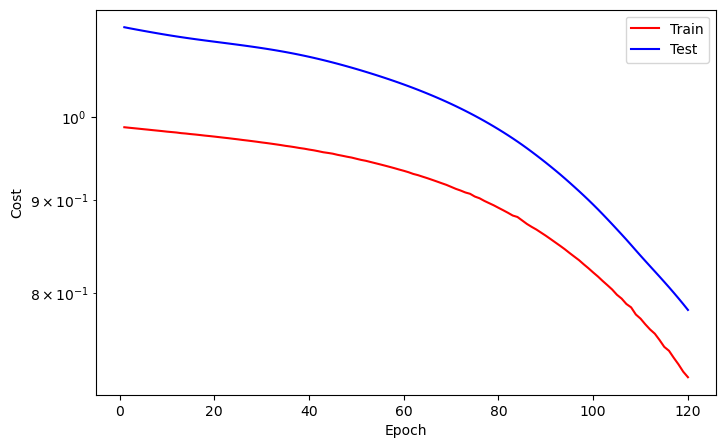

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.7119 | Test_cost  = 0.7772 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.7073 | Test_cost  = 0.7710 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.7012 | Test_cost  = 0.7647 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.6950 | Test_cost  = 0.7586 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.6882 | Test_cost  = 0.7523 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.6817 | Test_cost  = 0.7460 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.6750 | Test_cost  = 0.7396 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.6682 | Test_cost  = 0.7331 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.6613 | Test_cost  = 0.7264 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.6543 | Test_cost  = 0.7196 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.6464 | Test_cost  = 0.7122 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.6395 | Test_cost  = 0.7048 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.6327 | Test_cost  = 0.6974 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.6254 | Test_cost  = 0.6899 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.6177 | Test_cost  = 0.6824 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.6101 | Test_cost  = 0.6748 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.6026 | Test_cost  = 0.6672 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.5948 | Test_cost  = 0.6595 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.5883 | Test_cost  = 0.6516 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.5792 | Test_cost  = 0.6437 | 


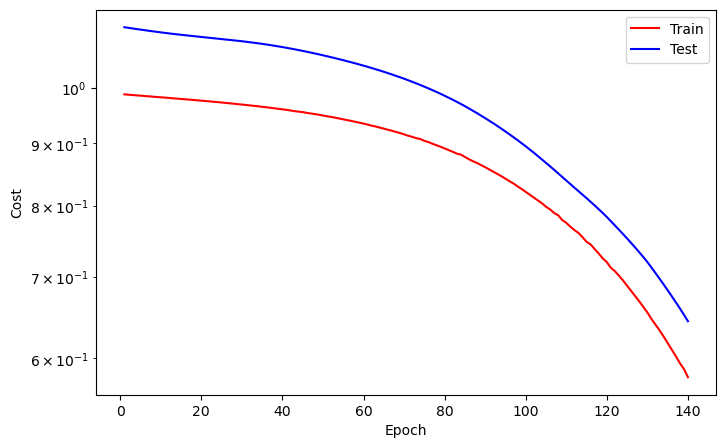

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.5712 | Test_cost  = 0.6356 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.5632 | Test_cost  = 0.6274 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.5551 | Test_cost  = 0.6190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.5470 | Test_cost  = 0.6106 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.5391 | Test_cost  = 0.6019 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.5306 | Test_cost  = 0.5932 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.5230 | Test_cost  = 0.5844 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.5147 | Test_cost  = 0.5756 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.5058 | Test_cost  = 0.5667 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.4975 | Test_cost  = 0.5578 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.4894 | Test_cost  = 0.5488 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.4809 | Test_cost  = 0.5398 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.4726 | Test_cost  = 0.5308 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.4644 | Test_cost  = 0.5219 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.4561 | Test_cost  = 0.5129 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.4486 | Test_cost  = 0.5040 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.4427 | Test_cost  = 0.4949 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.4317 | Test_cost  = 0.4859 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.4259 | Test_cost  = 0.4768 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.4162 | Test_cost  = 0.4679 | 


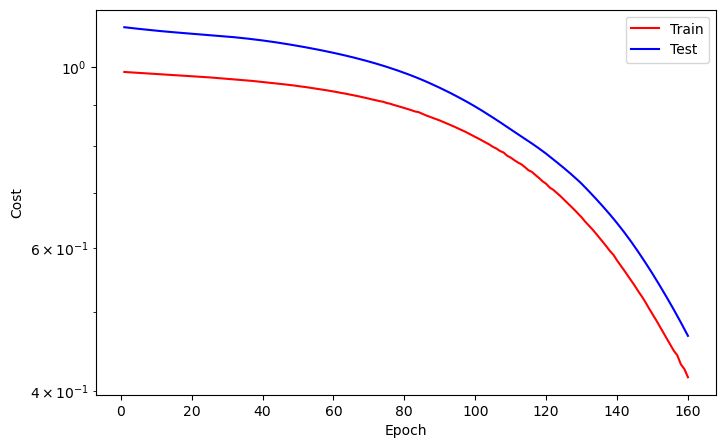

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.4077 | Test_cost  = 0.4591 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.3994 | Test_cost  = 0.4502 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.3921 | Test_cost  = 0.4415 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.3837 | Test_cost  = 0.4329 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.3769 | Test_cost  = 0.4243 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.3693 | Test_cost  = 0.4158 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.3623 | Test_cost  = 0.4074 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.3555 | Test_cost  = 0.3991 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.3480 | Test_cost  = 0.3910 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.3407 | Test_cost  = 0.3828 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.3340 | Test_cost  = 0.3749 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.3278 | Test_cost  = 0.3670 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.3208 | Test_cost  = 0.3595 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.3162 | Test_cost  = 0.3521 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.3083 | Test_cost  = 0.3449 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.3030 | Test_cost  = 0.3376 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.2967 | Test_cost  = 0.3308 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.2924 | Test_cost  = 0.3243 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.2856 | Test_cost  = 0.3180 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.2798 | Test_cost  = 0.3120 | 


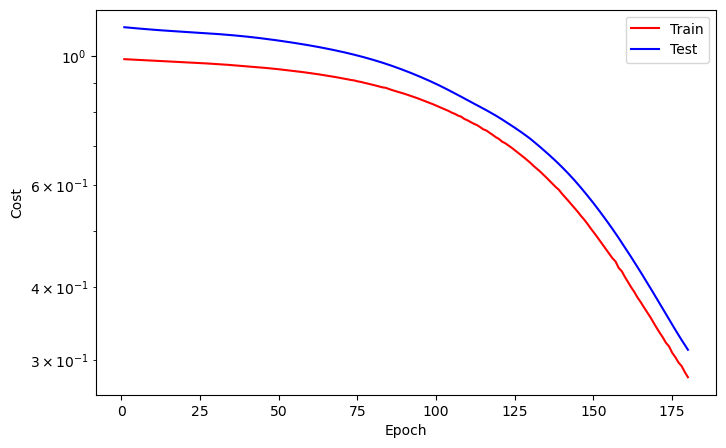

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.2753 | Test_cost  = 0.3063 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.2739 | Test_cost  = 0.3007 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.2655 | Test_cost  = 0.2954 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.2608 | Test_cost  = 0.2903 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.2575 | Test_cost  = 0.2854 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.2529 | Test_cost  = 0.2806 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.2491 | Test_cost  = 0.2759 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.2453 | Test_cost  = 0.2713 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.2414 | Test_cost  = 0.2669 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.2382 | Test_cost  = 0.2626 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.2356 | Test_cost  = 0.2585 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.2320 | Test_cost  = 0.2547 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.2291 | Test_cost  = 0.2509 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.2260 | Test_cost  = 0.2473 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.2235 | Test_cost  = 0.2440 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.2206 | Test_cost  = 0.2408 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.2196 | Test_cost  = 0.2376 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.2174 | Test_cost  = 0.2348 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.2121 | Test_cost  = 0.2322 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.2119 | Test_cost  = 0.2297 | 


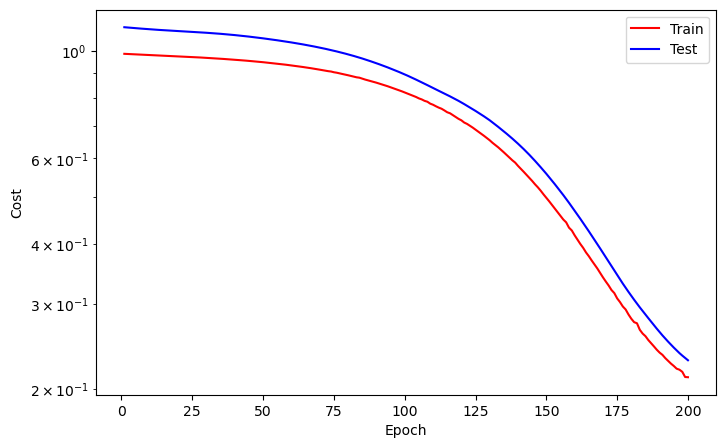

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.2098 | Test_cost  = 0.2271 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.2076 | Test_cost  = 0.2244 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.2061 | Test_cost  = 0.2218 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.2052 | Test_cost  = 0.2193 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.2023 | Test_cost  = 0.2170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.2019 | Test_cost  = 0.2147 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.1990 | Test_cost  = 0.2126 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.1975 | Test_cost  = 0.2104 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.1967 | Test_cost  = 0.2081 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.1956 | Test_cost  = 0.2059 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.1930 | Test_cost  = 0.2039 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.1915 | Test_cost  = 0.2021 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.1879 | Test_cost  = 0.2003 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.1888 | Test_cost  = 0.1986 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.1822 | Test_cost  = 0.1970 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.1880 | Test_cost  = 0.1954 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.1852 | Test_cost  = 0.1939 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.1828 | Test_cost  = 0.1926 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.1825 | Test_cost  = 0.1912 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.1812 | Test_cost  = 0.1897 | 


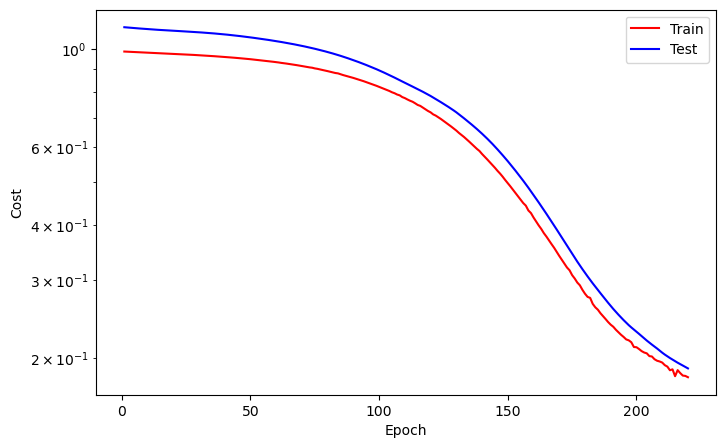

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.1800 | Test_cost  = 0.1883 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.1788 | Test_cost  = 0.1868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.1777 | Test_cost  = 0.1855 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.1765 | Test_cost  = 0.1841 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.1750 | Test_cost  = 0.1827 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.1803 | Test_cost  = 0.1816 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.1733 | Test_cost  = 0.1804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.1750 | Test_cost  = 0.1790 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.1708 | Test_cost  = 0.1778 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.1735 | Test_cost  = 0.1765 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.1682 | Test_cost  = 0.1753 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.1671 | Test_cost  = 0.1743 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.1676 | Test_cost  = 0.1733 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.1659 | Test_cost  = 0.1721 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.1667 | Test_cost  = 0.1709 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.1668 | Test_cost  = 0.1699 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.1625 | Test_cost  = 0.1689 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.1620 | Test_cost  = 0.1678 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.1613 | Test_cost  = 0.1669 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.1605 | Test_cost  = 0.1661 | 


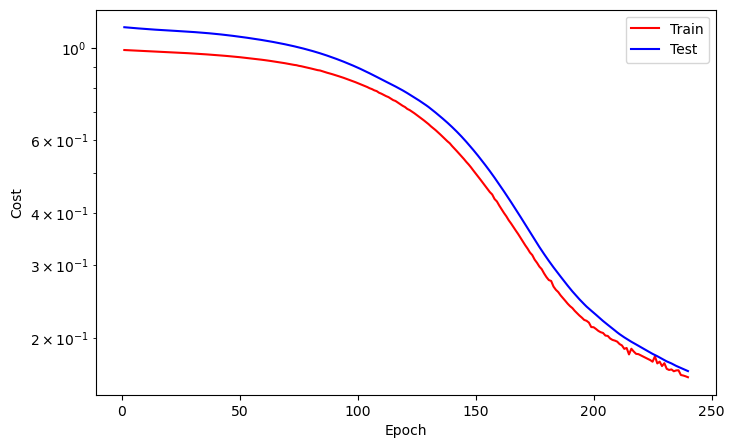

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.1586 | Test_cost  = 0.1653 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.1587 | Test_cost  = 0.1642 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.1575 | Test_cost  = 0.1631 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.1573 | Test_cost  = 0.1620 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.1555 | Test_cost  = 0.1610 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.1548 | Test_cost  = 0.1599 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.1539 | Test_cost  = 0.1589 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.1534 | Test_cost  = 0.1578 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.1506 | Test_cost  = 0.1562 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.1505 | Test_cost  = 0.1548 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.1506 | Test_cost  = 0.1537 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.1512 | Test_cost  = 0.1529 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.1489 | Test_cost  = 0.1523 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.1474 | Test_cost  = 0.1520 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.1529 | Test_cost  = 0.1519 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.1459 | Test_cost  = 0.1515 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.1484 | Test_cost  = 0.1507 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.1443 | Test_cost  = 0.1493 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.1433 | Test_cost  = 0.1477 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.1424 | Test_cost  = 0.1461 | 


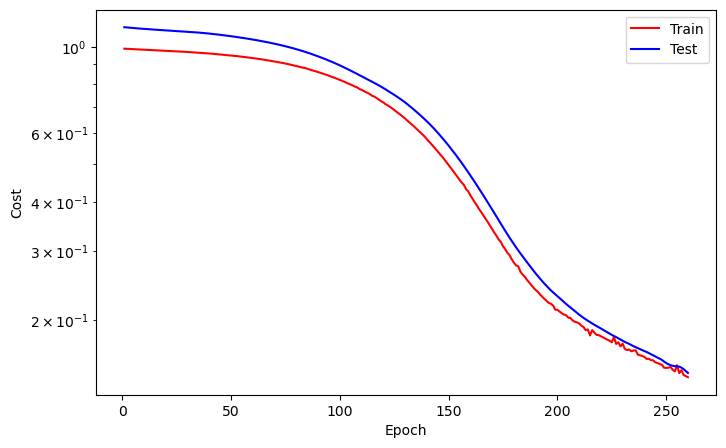

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.1416 | Test_cost  = 0.1442 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.1408 | Test_cost  = 0.1428 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.1414 | Test_cost  = 0.1420 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.1390 | Test_cost  = 0.1417 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.1381 | Test_cost  = 0.1417 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.1369 | Test_cost  = 0.1411 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.1389 | Test_cost  = 0.1405 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.1358 | Test_cost  = 0.1395 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.1348 | Test_cost  = 0.1384 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.1340 | Test_cost  = 0.1372 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.1331 | Test_cost  = 0.1362 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.1323 | Test_cost  = 0.1351 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.1338 | Test_cost  = 0.1342 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.1310 | Test_cost  = 0.1333 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.1297 | Test_cost  = 0.1325 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.1337 | Test_cost  = 0.1315 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.1283 | Test_cost  = 0.1304 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.1275 | Test_cost  = 0.1294 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.1274 | Test_cost  = 0.1285 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.1288 | Test_cost  = 0.1281 | 


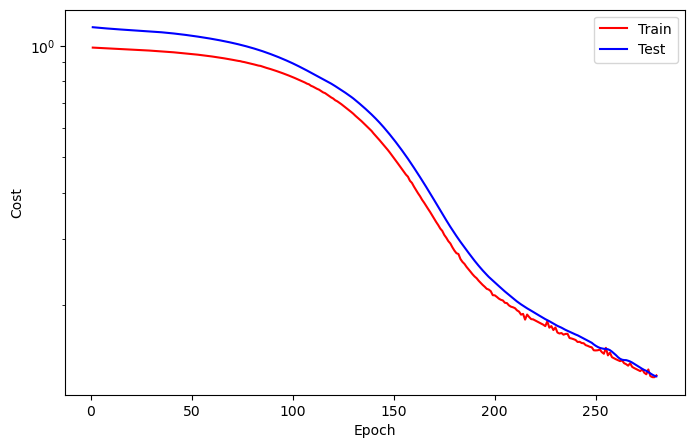

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.1256 | Test_cost  = 0.1276 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.1257 | Test_cost  = 0.1267 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.1243 | Test_cost  = 0.1255 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.1236 | Test_cost  = 0.1243 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.1221 | Test_cost  = 0.1232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 0.1251 | Test_cost  = 0.1221 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 0.1237 | Test_cost  = 0.1226 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1221


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 0.1232 | Test_cost  = 0.1218 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 0.1215 | Test_cost  = 0.1217 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 0.1247 | Test_cost  = 0.1218 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1217


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 0.1211 | Test_cost  = 0.1206 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 0.1273 | Test_cost  = 0.1187 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 0.1190 | Test_cost  = 0.1176 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 0.1182 | Test_cost  = 0.1168 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 0.1190 | Test_cost  = 0.1161 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 0.1173 | Test_cost  = 0.1159 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 0.1199 | Test_cost  = 0.1162 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1159


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 0.1173 | Test_cost  = 0.1159 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 0.1171 | Test_cost  = 0.1148 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 0.1171 | Test_cost  = 0.1143 | 


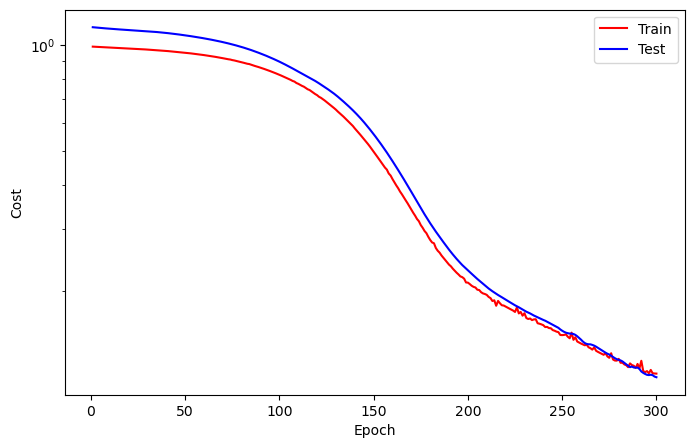

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 0.1214 | Test_cost  = 0.1134 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 0.1150 | Test_cost  = 0.1128 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 0.1154 | Test_cost  = 0.1125 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 0.1149 | Test_cost  = 0.1123 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 0.1169 | Test_cost  = 0.1121 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 0.1144 | Test_cost  = 0.1117 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 0.1139 | Test_cost  = 0.1112 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 0.1139 | Test_cost  = 0.1108 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 0.1148 | Test_cost  = 0.1103 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 0.1152 | Test_cost  = 0.1097 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 0.1134 | Test_cost  = 0.1092 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 0.1132 | Test_cost  = 0.1088 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 0.1128 | Test_cost  = 0.1085 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 0.1124 | Test_cost  = 0.1083 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 0.1122 | Test_cost  = 0.1084 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1083


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 0.1135 | Test_cost  = 0.1085 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1083


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 0.1118 | Test_cost  = 0.1085 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1083


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 0.1159 | Test_cost  = 0.1075 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 0.1114 | Test_cost  = 0.1065 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 0.1108 | Test_cost  = 0.1060 | 


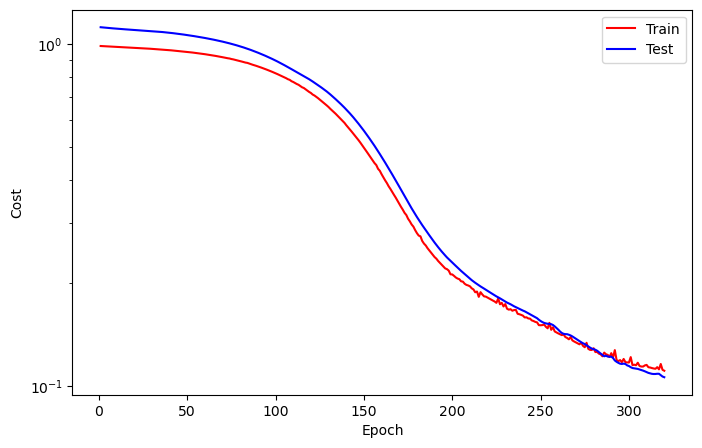

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 0.1110 | Test_cost  = 0.1059 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 0.1111 | Test_cost  = 0.1061 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1059


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 0.1107 | Test_cost  = 0.1064 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1059


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 0.1158 | Test_cost  = 0.1068 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1059


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 0.1108 | Test_cost  = 0.1066 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1059


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 0.1109 | Test_cost  = 0.1063 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1059
==> Execute Early Stopping at epoch: 326 | Best test_cost: 0.1059
==> Best model is saved at model/lstm


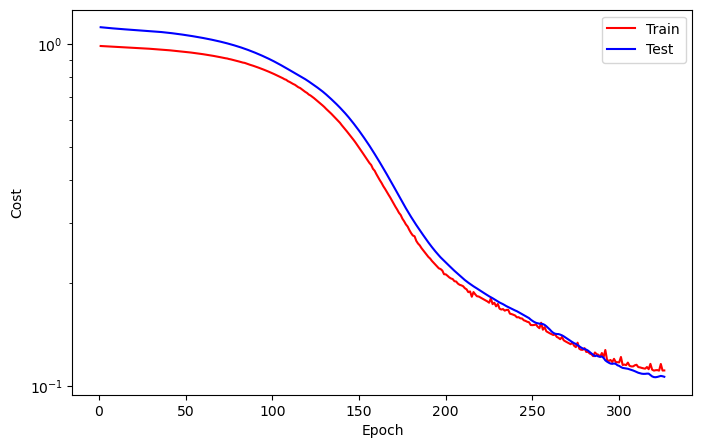

In [25]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Forecast

In [26]:
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [27]:
train_forecast_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (203, 1, 1)
Note: last 0 data excluded

(N, S, F): (50, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

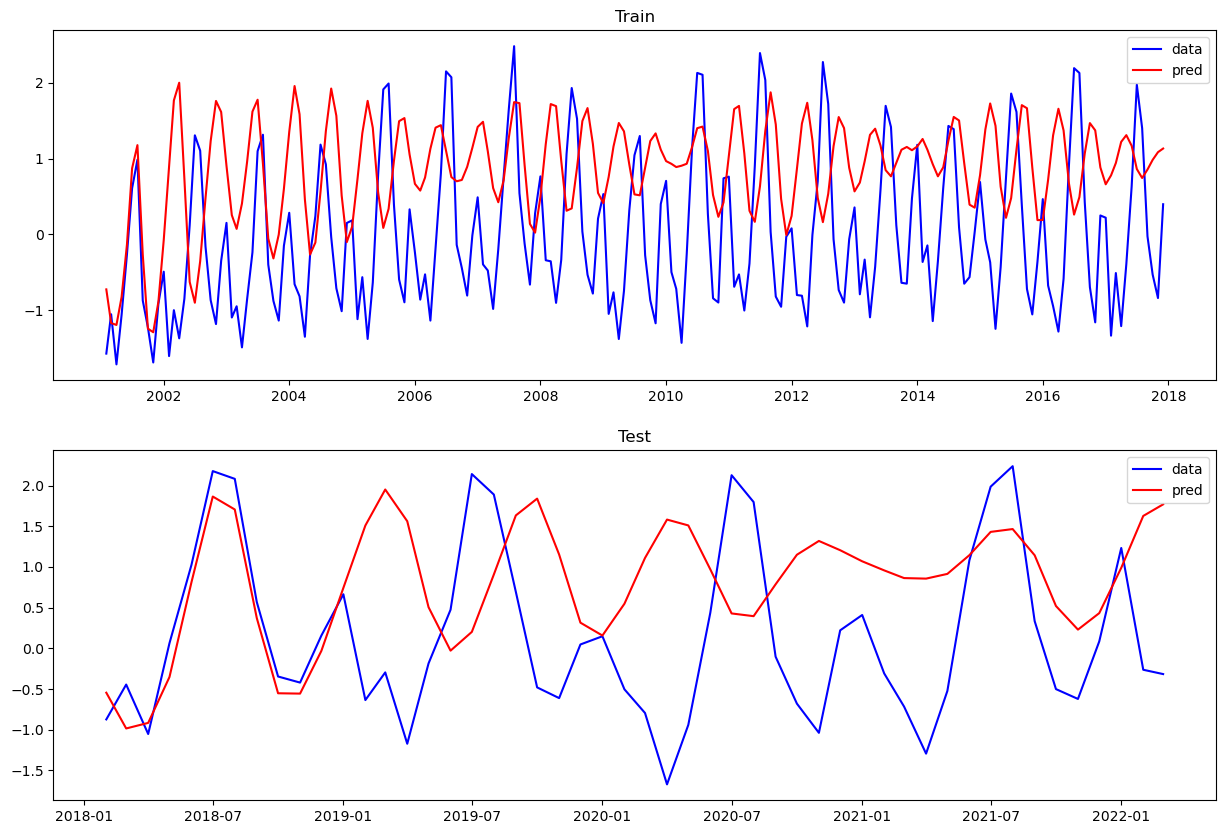

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

IndexError: index 75 is out of bounds for axis 0 with size 50

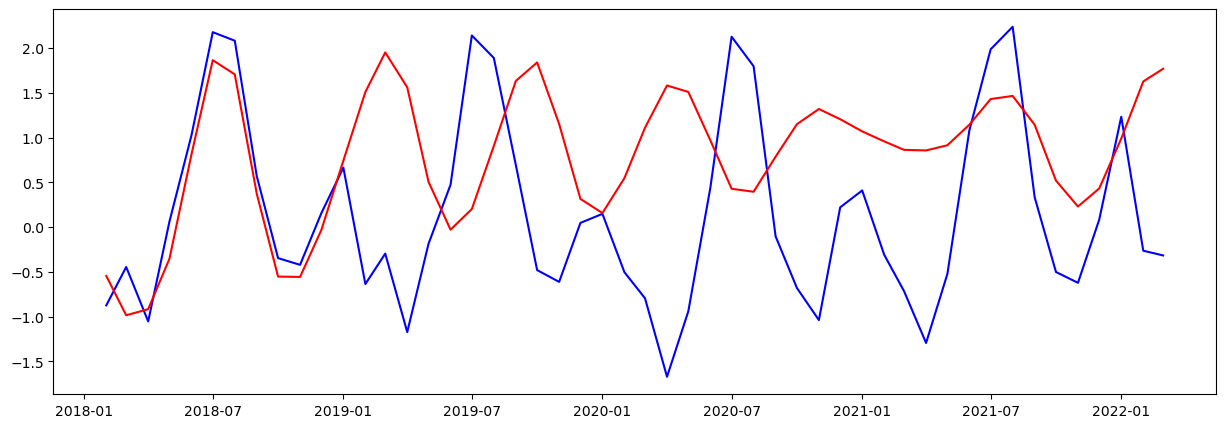

In [29]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

# With GRU 

In [30]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [31]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 8,
    'num_layers': 2,
    'dropout': 0.001,
    'seq_len': train_set.n_seq
})

In [32]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

In [33]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.1195 | Test_cost  = 1.4246 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.1123 | Test_cost  = 1.4141 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.1053 | Test_cost  = 1.4038 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.0984 | Test_cost  = 1.3936 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.0914 | Test_cost  = 1.3835 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.0847 | Test_cost  = 1.3734 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.0781 | Test_cost  = 1.3635 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.0714 | Test_cost  = 1.3536 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.0650 | Test_cost  = 1.3439 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.0586 | Test_cost  = 1.3342 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.0525 | Test_cost  = 1.3247 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1.0462 | Test_cost  = 1.3153 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 1.0401 | Test_cost  = 1.3060 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 1.0341 | Test_cost  = 1.2968 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 1.0283 | Test_cost  = 1.2877 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 1.0226 | Test_cost  = 1.2787 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 1.0170 | Test_cost  = 1.2698 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 1.0115 | Test_cost  = 1.2610 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 1.0061 | Test_cost  = 1.2523 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 1.0009 | Test_cost  = 1.2437 | 


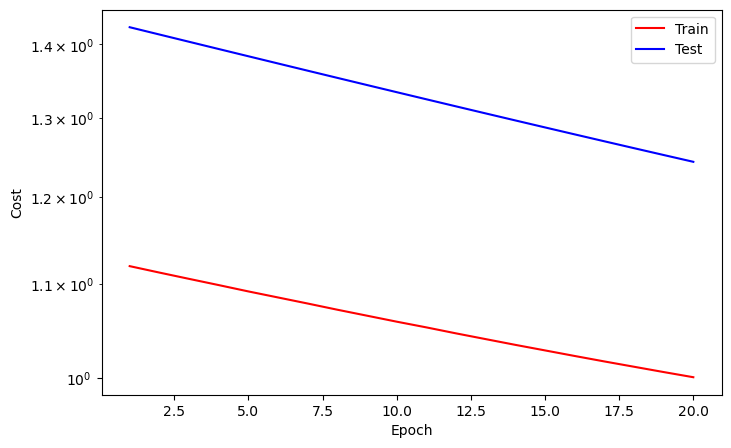

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.9953 | Test_cost  = 1.2353 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.9904 | Test_cost  = 1.2269 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.9856 | Test_cost  = 1.2187 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.9805 | Test_cost  = 1.2106 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.9760 | Test_cost  = 1.2025 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.9710 | Test_cost  = 1.1946 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.9665 | Test_cost  = 1.1868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.9619 | Test_cost  = 1.1791 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.9577 | Test_cost  = 1.1715 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.9538 | Test_cost  = 1.1640 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.9490 | Test_cost  = 1.1566 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.9451 | Test_cost  = 1.1494 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.9410 | Test_cost  = 1.1422 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.9372 | Test_cost  = 1.1352 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.9333 | Test_cost  = 1.1282 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.9297 | Test_cost  = 1.1214 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.9263 | Test_cost  = 1.1147 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.9226 | Test_cost  = 1.1081 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.9192 | Test_cost  = 1.1016 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.9164 | Test_cost  = 1.0952 | 


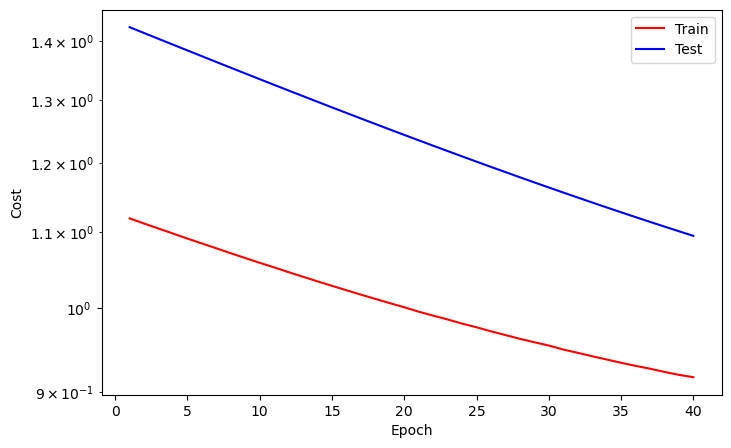

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.9129 | Test_cost  = 1.0889 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.9099 | Test_cost  = 1.0827 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.9071 | Test_cost  = 1.0767 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.9048 | Test_cost  = 1.0707 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.9005 | Test_cost  = 1.0649 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.8977 | Test_cost  = 1.0591 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.8945 | Test_cost  = 1.0535 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.8925 | Test_cost  = 1.0480 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.8898 | Test_cost  = 1.0426 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.8882 | Test_cost  = 1.0373 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.8848 | Test_cost  = 1.0320 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.8821 | Test_cost  = 1.0269 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.8798 | Test_cost  = 1.0219 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.8774 | Test_cost  = 1.0170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.8752 | Test_cost  = 1.0122 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.8734 | Test_cost  = 1.0074 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.8706 | Test_cost  = 1.0028 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.8684 | Test_cost  = 0.9982 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.8662 | Test_cost  = 0.9938 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.8640 | Test_cost  = 0.9894 | 


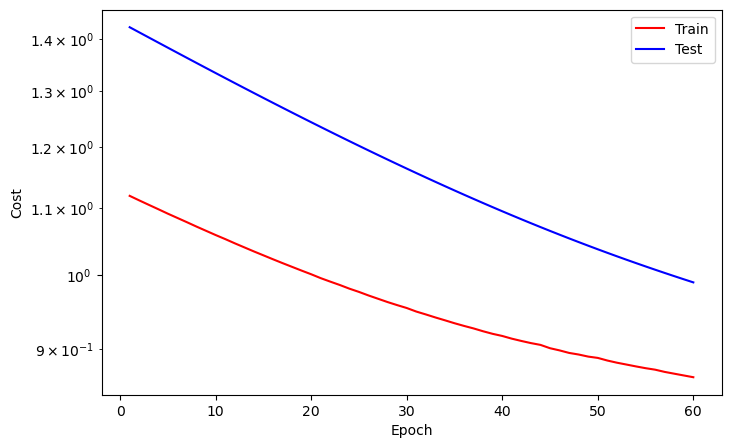

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.8621 | Test_cost  = 0.9850 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.8595 | Test_cost  = 0.9808 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.8575 | Test_cost  = 0.9766 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.8553 | Test_cost  = 0.9725 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.8531 | Test_cost  = 0.9685 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.8510 | Test_cost  = 0.9645 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.8488 | Test_cost  = 0.9606 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.8466 | Test_cost  = 0.9567 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.8443 | Test_cost  = 0.9529 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.8420 | Test_cost  = 0.9491 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.8398 | Test_cost  = 0.9454 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.8374 | Test_cost  = 0.9417 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.8358 | Test_cost  = 0.9380 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.8331 | Test_cost  = 0.9344 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.8303 | Test_cost  = 0.9308 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.8276 | Test_cost  = 0.9272 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.8255 | Test_cost  = 0.9236 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.8226 | Test_cost  = 0.9200 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.8200 | Test_cost  = 0.9165 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.8172 | Test_cost  = 0.9129 | 


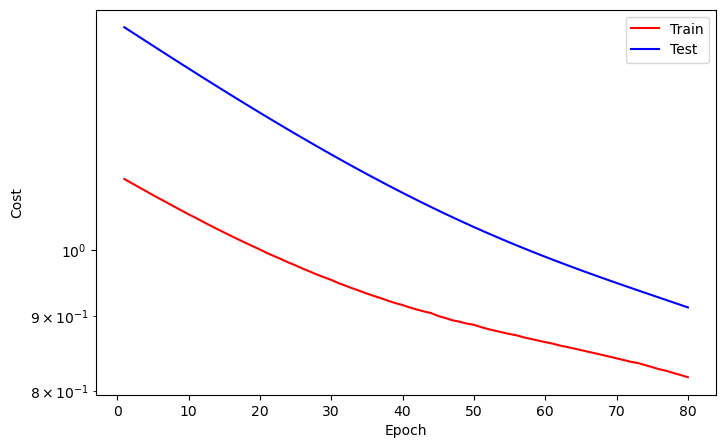

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.8145 | Test_cost  = 0.9094 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.8118 | Test_cost  = 0.9059 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.8089 | Test_cost  = 0.9023 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.8058 | Test_cost  = 0.8988 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.8028 | Test_cost  = 0.8952 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.7998 | Test_cost  = 0.8916 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.7967 | Test_cost  = 0.8880 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.7935 | Test_cost  = 0.8844 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.7908 | Test_cost  = 0.8807 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.7868 | Test_cost  = 0.8770 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.7836 | Test_cost  = 0.8733 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.7802 | Test_cost  = 0.8696 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.7769 | Test_cost  = 0.8658 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.7731 | Test_cost  = 0.8619 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.7695 | Test_cost  = 0.8581 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.7659 | Test_cost  = 0.8541 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.7622 | Test_cost  = 0.8502 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.7585 | Test_cost  = 0.8461 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.7555 | Test_cost  = 0.8421 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.7506 | Test_cost  = 0.8380 | 


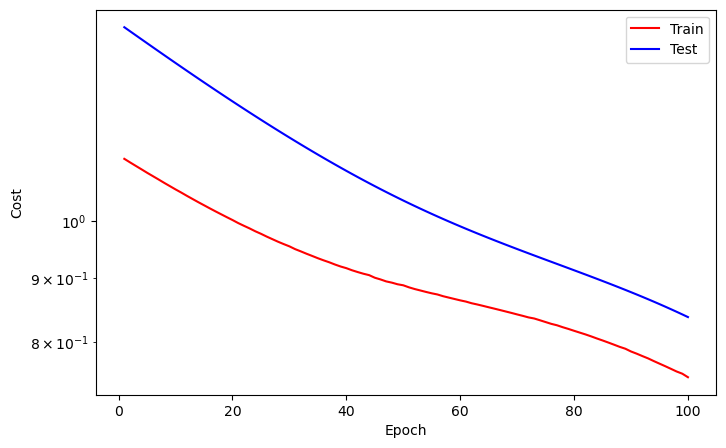

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.7467 | Test_cost  = 0.8338 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.7427 | Test_cost  = 0.8295 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.7386 | Test_cost  = 0.8253 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.7344 | Test_cost  = 0.8209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.7301 | Test_cost  = 0.8165 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.7261 | Test_cost  = 0.8120 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.7217 | Test_cost  = 0.8075 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.7167 | Test_cost  = 0.8029 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.7132 | Test_cost  = 0.7983 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.7086 | Test_cost  = 0.7936 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.7043 | Test_cost  = 0.7888 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.6994 | Test_cost  = 0.7840 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.6949 | Test_cost  = 0.7791 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.6901 | Test_cost  = 0.7742 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 0.6854 | Test_cost  = 0.7692 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 0.6806 | Test_cost  = 0.7641 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 0.6759 | Test_cost  = 0.7590 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 0.6713 | Test_cost  = 0.7539 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.6665 | Test_cost  = 0.7487 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.6613 | Test_cost  = 0.7435 | 


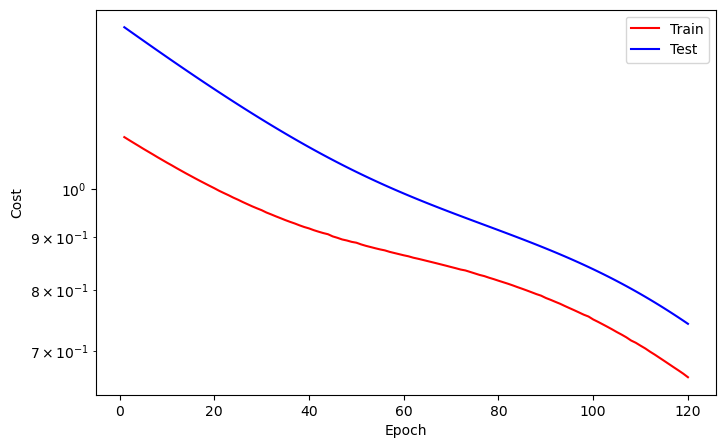

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.6561 | Test_cost  = 0.7382 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.6513 | Test_cost  = 0.7328 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.6461 | Test_cost  = 0.7275 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.6419 | Test_cost  = 0.7221 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.6368 | Test_cost  = 0.7166 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.6321 | Test_cost  = 0.7112 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.6257 | Test_cost  = 0.7057 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.6204 | Test_cost  = 0.7001 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.6152 | Test_cost  = 0.6946 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.6099 | Test_cost  = 0.6890 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.6046 | Test_cost  = 0.6834 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.5996 | Test_cost  = 0.6778 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.5938 | Test_cost  = 0.6721 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.5887 | Test_cost  = 0.6665 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.5833 | Test_cost  = 0.6608 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.5780 | Test_cost  = 0.6551 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.5731 | Test_cost  = 0.6494 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.5672 | Test_cost  = 0.6437 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.5631 | Test_cost  = 0.6380 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.5574 | Test_cost  = 0.6323 | 


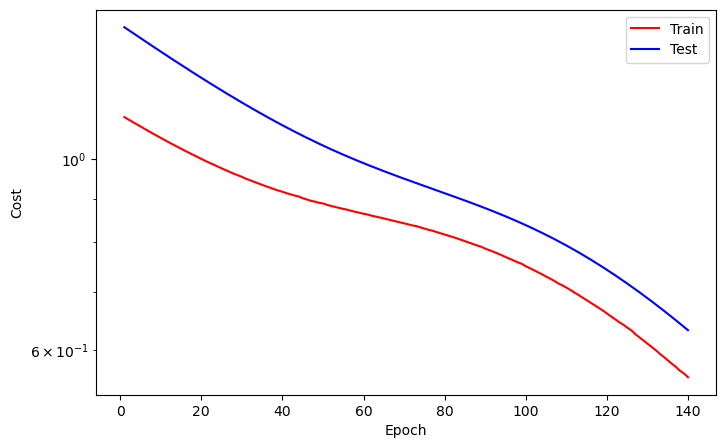

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.5512 | Test_cost  = 0.6266 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.5457 | Test_cost  = 0.6209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.5410 | Test_cost  = 0.6151 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.5346 | Test_cost  = 0.6094 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.5292 | Test_cost  = 0.6037 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.5243 | Test_cost  = 0.5980 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.5186 | Test_cost  = 0.5923 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.5132 | Test_cost  = 0.5865 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.5074 | Test_cost  = 0.5808 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.5024 | Test_cost  = 0.5751 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.4971 | Test_cost  = 0.5694 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.4928 | Test_cost  = 0.5638 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.4864 | Test_cost  = 0.5581 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.4812 | Test_cost  = 0.5525 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.4753 | Test_cost  = 0.5469 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.4707 | Test_cost  = 0.5413 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.4670 | Test_cost  = 0.5358 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.4603 | Test_cost  = 0.5302 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.4550 | Test_cost  = 0.5247 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.4514 | Test_cost  = 0.5192 | 


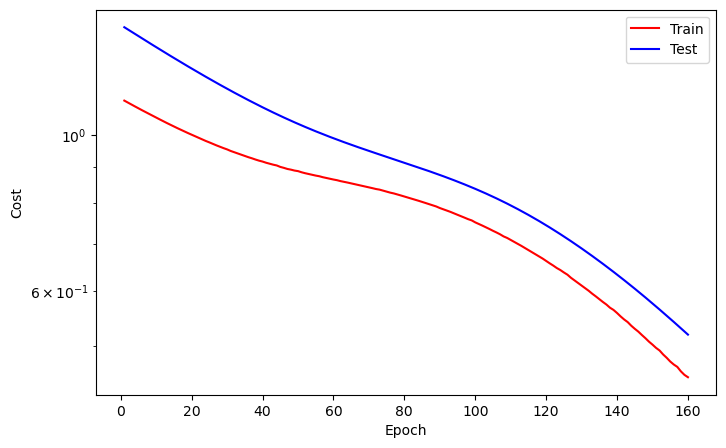

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.4449 | Test_cost  = 0.5138 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.4412 | Test_cost  = 0.5083 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.4364 | Test_cost  = 0.5029 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.4316 | Test_cost  = 0.4975 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.4251 | Test_cost  = 0.4922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.4207 | Test_cost  = 0.4869 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.4162 | Test_cost  = 0.4816 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.4106 | Test_cost  = 0.4763 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.4072 | Test_cost  = 0.4711 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.4006 | Test_cost  = 0.4660 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.3967 | Test_cost  = 0.4608 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.3921 | Test_cost  = 0.4558 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.3876 | Test_cost  = 0.4507 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.3831 | Test_cost  = 0.4458 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.3793 | Test_cost  = 0.4409 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.3745 | Test_cost  = 0.4360 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.3702 | Test_cost  = 0.4312 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.3663 | Test_cost  = 0.4265 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.3620 | Test_cost  = 0.4218 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.3583 | Test_cost  = 0.4172 | 


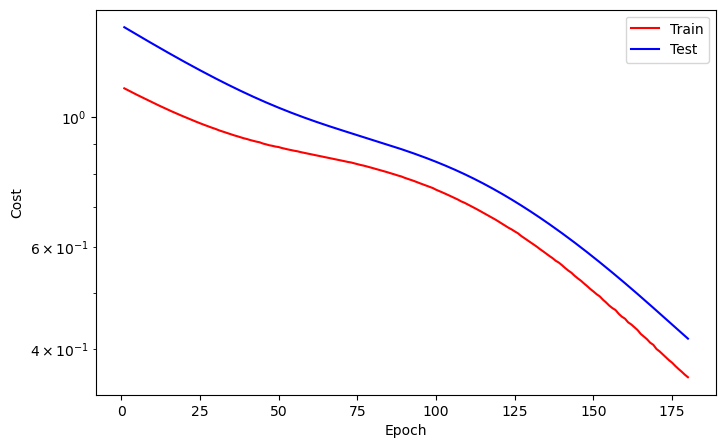

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.3539 | Test_cost  = 0.4127 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.3500 | Test_cost  = 0.4082 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.3473 | Test_cost  = 0.4038 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.3426 | Test_cost  = 0.3994 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.3385 | Test_cost  = 0.3952 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.3351 | Test_cost  = 0.3910 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.3311 | Test_cost  = 0.3869 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.3277 | Test_cost  = 0.3828 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.3242 | Test_cost  = 0.3788 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.3208 | Test_cost  = 0.3748 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.3175 | Test_cost  = 0.3709 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.3155 | Test_cost  = 0.3671 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.3109 | Test_cost  = 0.3634 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.3078 | Test_cost  = 0.3597 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.3048 | Test_cost  = 0.3560 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.3027 | Test_cost  = 0.3524 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.2991 | Test_cost  = 0.3489 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.2959 | Test_cost  = 0.3455 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.2918 | Test_cost  = 0.3421 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.2915 | Test_cost  = 0.3388 | 


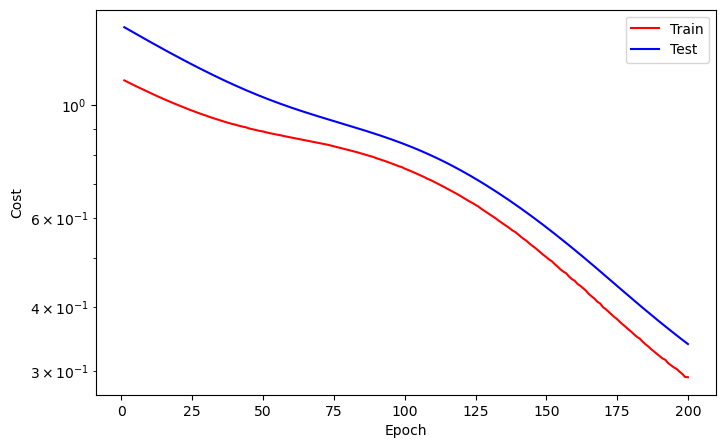

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.2875 | Test_cost  = 0.3356 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.2858 | Test_cost  = 0.3324 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.2823 | Test_cost  = 0.3293 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.2797 | Test_cost  = 0.3262 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.2769 | Test_cost  = 0.3232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.2752 | Test_cost  = 0.3203 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.2716 | Test_cost  = 0.3174 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.2702 | Test_cost  = 0.3145 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.2687 | Test_cost  = 0.3117 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.2668 | Test_cost  = 0.3090 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.2641 | Test_cost  = 0.3063 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.2619 | Test_cost  = 0.3037 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.2586 | Test_cost  = 0.3012 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.2572 | Test_cost  = 0.2986 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.2553 | Test_cost  = 0.2962 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.2536 | Test_cost  = 0.2938 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.2515 | Test_cost  = 0.2914 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.2502 | Test_cost  = 0.2891 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.2477 | Test_cost  = 0.2868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.2467 | Test_cost  = 0.2847 | 


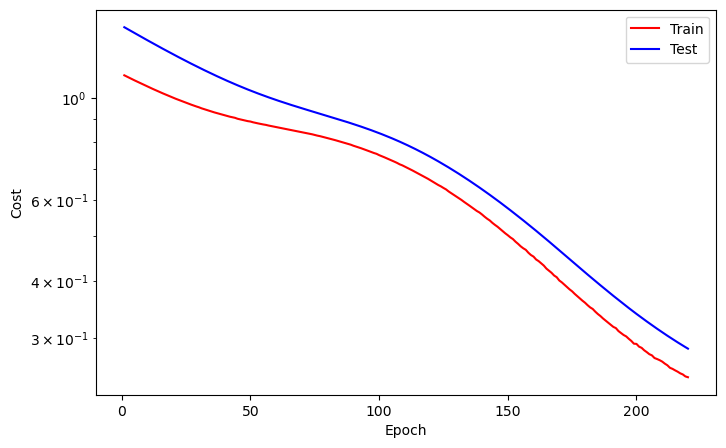

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.2437 | Test_cost  = 0.2825 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.2432 | Test_cost  = 0.2804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.2411 | Test_cost  = 0.2783 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.2395 | Test_cost  = 0.2762 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.2378 | Test_cost  = 0.2742 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.2371 | Test_cost  = 0.2723 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.2349 | Test_cost  = 0.2703 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.2335 | Test_cost  = 0.2685 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.2344 | Test_cost  = 0.2667 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.2309 | Test_cost  = 0.2649 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.2293 | Test_cost  = 0.2631 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.2285 | Test_cost  = 0.2614 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.2258 | Test_cost  = 0.2597 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.2255 | Test_cost  = 0.2581 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.2243 | Test_cost  = 0.2565 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.2229 | Test_cost  = 0.2549 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.2224 | Test_cost  = 0.2534 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.2205 | Test_cost  = 0.2518 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.2212 | Test_cost  = 0.2504 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.2186 | Test_cost  = 0.2489 | 


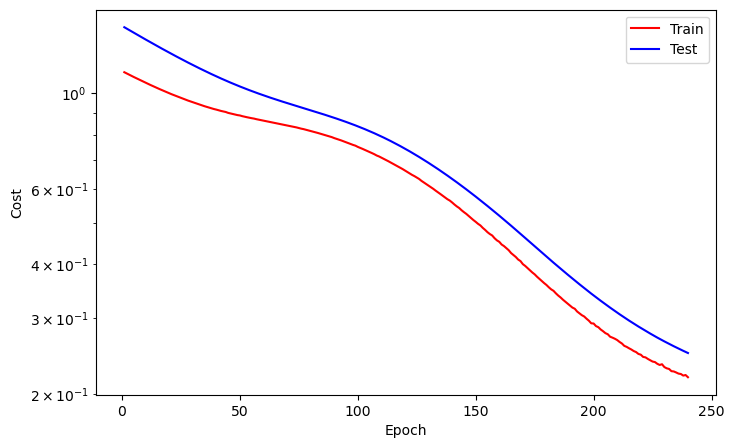

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.2175 | Test_cost  = 0.2475 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.2154 | Test_cost  = 0.2460 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.2155 | Test_cost  = 0.2447 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.2137 | Test_cost  = 0.2434 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.2130 | Test_cost  = 0.2421 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.2118 | Test_cost  = 0.2408 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.2112 | Test_cost  = 0.2396 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.2098 | Test_cost  = 0.2384 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.2103 | Test_cost  = 0.2373 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.2081 | Test_cost  = 0.2361 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.2080 | Test_cost  = 0.2350 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.2072 | Test_cost  = 0.2338 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.2054 | Test_cost  = 0.2327 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.2053 | Test_cost  = 0.2315 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.2034 | Test_cost  = 0.2304 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.2041 | Test_cost  = 0.2293 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.2023 | Test_cost  = 0.2282 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.2020 | Test_cost  = 0.2270 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.2003 | Test_cost  = 0.2259 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.2000 | Test_cost  = 0.2248 | 


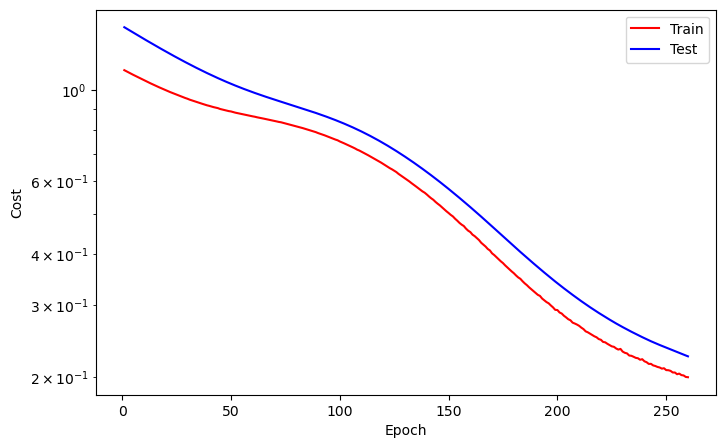

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.1989 | Test_cost  = 0.2238 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.1979 | Test_cost  = 0.2227 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.1969 | Test_cost  = 0.2217 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.1972 | Test_cost  = 0.2207 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.1952 | Test_cost  = 0.2198 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.1950 | Test_cost  = 0.2188 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.1940 | Test_cost  = 0.2179 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.1932 | Test_cost  = 0.2170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.1915 | Test_cost  = 0.2161 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.1919 | Test_cost  = 0.2152 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.1916 | Test_cost  = 0.2144 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.1902 | Test_cost  = 0.2135 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.1905 | Test_cost  = 0.2127 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.1890 | Test_cost  = 0.2118 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.1888 | Test_cost  = 0.2110 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.1876 | Test_cost  = 0.2101 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.1868 | Test_cost  = 0.2093 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.1850 | Test_cost  = 0.2085 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.1862 | Test_cost  = 0.2076 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.1850 | Test_cost  = 0.2068 | 


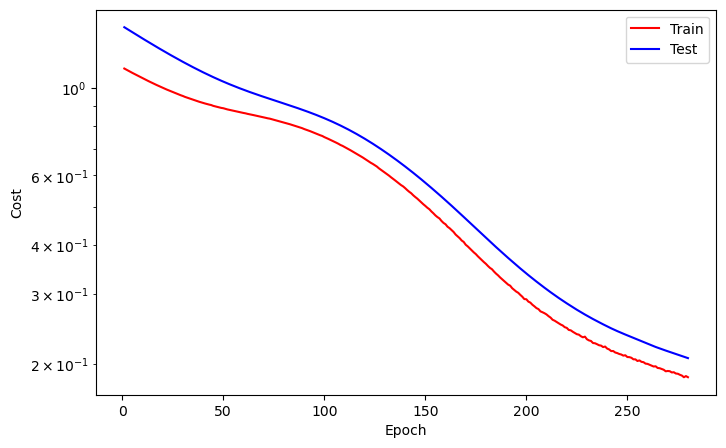

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.1841 | Test_cost  = 0.2060 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.1836 | Test_cost  = 0.2051 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.1831 | Test_cost  = 0.2043 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.1824 | Test_cost  = 0.2035 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.1818 | Test_cost  = 0.2027 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 0.1810 | Test_cost  = 0.2019 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 0.1805 | Test_cost  = 0.2012 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 0.1800 | Test_cost  = 0.2005 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 0.1791 | Test_cost  = 0.1997 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 0.1786 | Test_cost  = 0.1990 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 0.1782 | Test_cost  = 0.1984 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 0.1780 | Test_cost  = 0.1977 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 0.1769 | Test_cost  = 0.1970 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 0.1759 | Test_cost  = 0.1963 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 0.1757 | Test_cost  = 0.1956 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 0.1751 | Test_cost  = 0.1949 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 0.1746 | Test_cost  = 0.1942 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 0.1713 | Test_cost  = 0.1936 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 0.1736 | Test_cost  = 0.1930 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 0.1722 | Test_cost  = 0.1924 | 


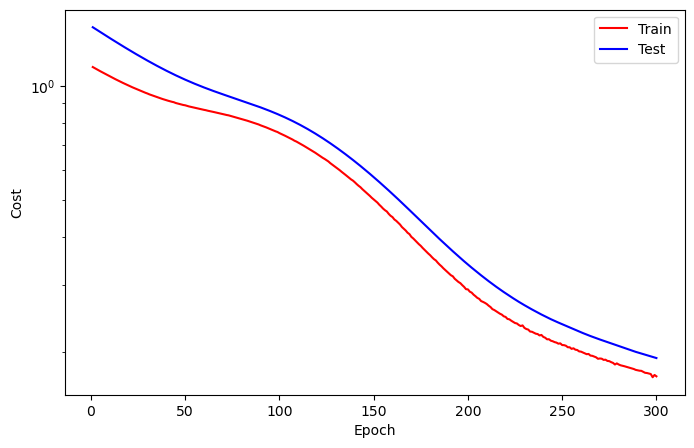

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 0.1735 | Test_cost  = 0.1917 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 0.1716 | Test_cost  = 0.1911 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 0.1730 | Test_cost  = 0.1905 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 0.1706 | Test_cost  = 0.1898 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 0.1701 | Test_cost  = 0.1892 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 0.1695 | Test_cost  = 0.1885 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 0.1690 | Test_cost  = 0.1878 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 0.1683 | Test_cost  = 0.1871 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 0.1685 | Test_cost  = 0.1864 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 0.1683 | Test_cost  = 0.1857 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 0.1657 | Test_cost  = 0.1850 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 0.1658 | Test_cost  = 0.1844 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 0.1665 | Test_cost  = 0.1839 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 0.1652 | Test_cost  = 0.1834 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 0.1648 | Test_cost  = 0.1829 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 0.1641 | Test_cost  = 0.1824 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 0.1646 | Test_cost  = 0.1819 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 0.1633 | Test_cost  = 0.1814 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 0.1631 | Test_cost  = 0.1809 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 0.1624 | Test_cost  = 0.1803 | 


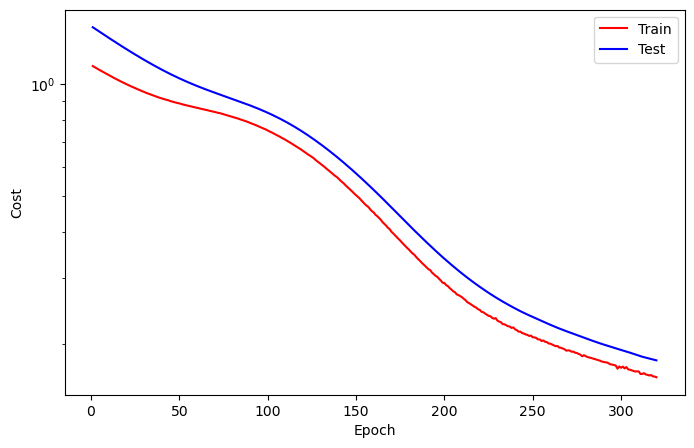

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 0.1628 | Test_cost  = 0.1799 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 0.1615 | Test_cost  = 0.1794 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 0.1608 | Test_cost  = 0.1788 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 0.1607 | Test_cost  = 0.1783 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 0.1609 | Test_cost  = 0.1777 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 0.1592 | Test_cost  = 0.1771 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 0.1584 | Test_cost  = 0.1765 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 0.1591 | Test_cost  = 0.1759 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 0.1579 | Test_cost  = 0.1753 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 0.1575 | Test_cost  = 0.1748 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 0.1575 | Test_cost  = 0.1742 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 0.1565 | Test_cost  = 0.1737 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 0.1561 | Test_cost  = 0.1732 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 0.1560 | Test_cost  = 0.1727 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 0.1552 | Test_cost  = 0.1722 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 0.1546 | Test_cost  = 0.1716 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 0.1545 | Test_cost  = 0.1711 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 0.1539 | Test_cost  = 0.1705 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 0.1534 | Test_cost  = 0.1700 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 0.1534 | Test_cost  = 0.1696 | 


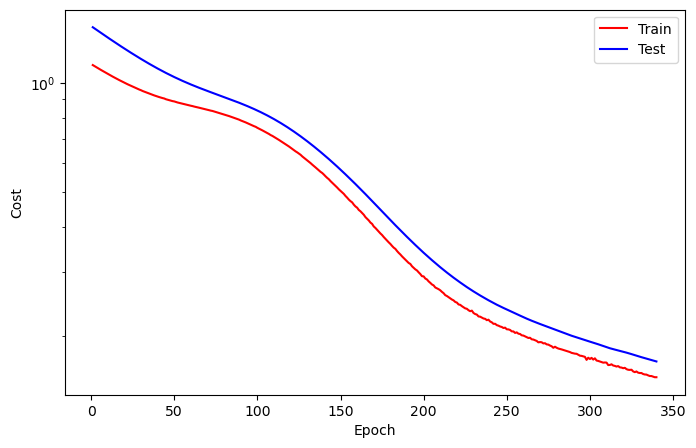

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 0.1527 | Test_cost  = 0.1691 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 0.1512 | Test_cost  = 0.1687 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 0.1515 | Test_cost  = 0.1683 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 0.1511 | Test_cost  = 0.1680 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 0.1506 | Test_cost  = 0.1675 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 0.1505 | Test_cost  = 0.1671 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 0.1496 | Test_cost  = 0.1666 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 0.1493 | Test_cost  = 0.1660 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 0.1481 | Test_cost  = 0.1655 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 0.1487 | Test_cost  = 0.1649 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 0.1479 | Test_cost  = 0.1644 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 0.1474 | Test_cost  = 0.1638 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 0.1474 | Test_cost  = 0.1633 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 0.1468 | Test_cost  = 0.1628 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 0.1463 | Test_cost  = 0.1623 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 0.1459 | Test_cost  = 0.1619 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 0.1454 | Test_cost  = 0.1615 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 0.1444 | Test_cost  = 0.1611 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 0.1446 | Test_cost  = 0.1607 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 0.1443 | Test_cost  = 0.1603 | 


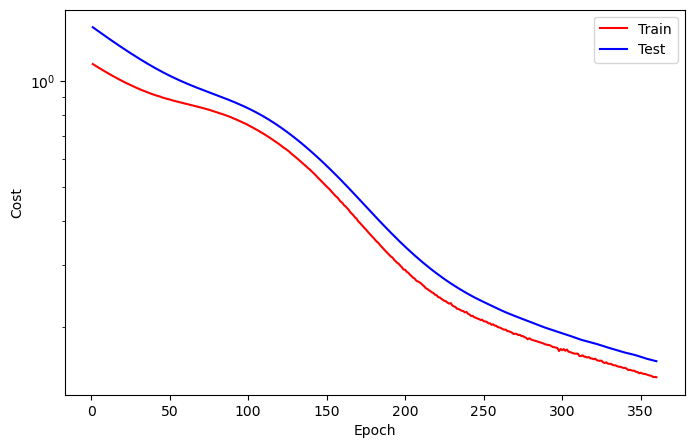

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 0.1440 | Test_cost  = 0.1599 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 0.1432 | Test_cost  = 0.1595 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 0.1427 | Test_cost  = 0.1591 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 0.1422 | Test_cost  = 0.1587 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 0.1413 | Test_cost  = 0.1584 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 0.1433 | Test_cost  = 0.1580 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 0.1413 | Test_cost  = 0.1576 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 0.1410 | Test_cost  = 0.1572 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 0.1406 | Test_cost  = 0.1567 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 0.1398 | Test_cost  = 0.1562 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 0.1394 | Test_cost  = 0.1557 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 0.1401 | Test_cost  = 0.1552 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 0.1390 | Test_cost  = 0.1547 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 0.1386 | Test_cost  = 0.1543 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   375
Train_cost  = 0.1399 | Test_cost  = 0.1539 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   376
Train_cost  = 0.1379 | Test_cost  = 0.1535 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   377
Train_cost  = 0.1369 | Test_cost  = 0.1531 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   378
Train_cost  = 0.1377 | Test_cost  = 0.1528 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   379
Train_cost  = 0.1367 | Test_cost  = 0.1524 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   380
Train_cost  = 0.1365 | Test_cost  = 0.1520 | 


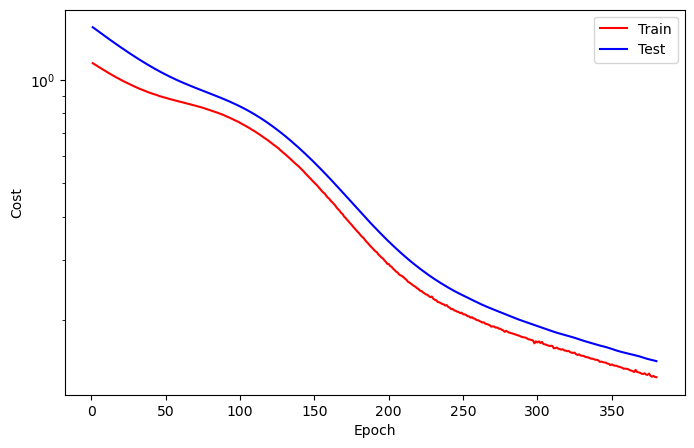

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   381
Train_cost  = 0.1368 | Test_cost  = 0.1517 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   382
Train_cost  = 0.1356 | Test_cost  = 0.1514 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 0.1355 | Test_cost  = 0.1510 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 0.1353 | Test_cost  = 0.1506 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 0.1351 | Test_cost  = 0.1502 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 0.1339 | Test_cost  = 0.1498 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 0.1335 | Test_cost  = 0.1493 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 0.1345 | Test_cost  = 0.1489 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 0.1333 | Test_cost  = 0.1486 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 0.1342 | Test_cost  = 0.1482 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 0.1323 | Test_cost  = 0.1479 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 0.1320 | Test_cost  = 0.1476 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 0.1323 | Test_cost  = 0.1473 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 0.1312 | Test_cost  = 0.1469 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 0.1306 | Test_cost  = 0.1466 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 0.1321 | Test_cost  = 0.1464 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 0.1307 | Test_cost  = 0.1462 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 0.1298 | Test_cost  = 0.1458 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 0.1296 | Test_cost  = 0.1453 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 0.1293 | Test_cost  = 0.1448 | 


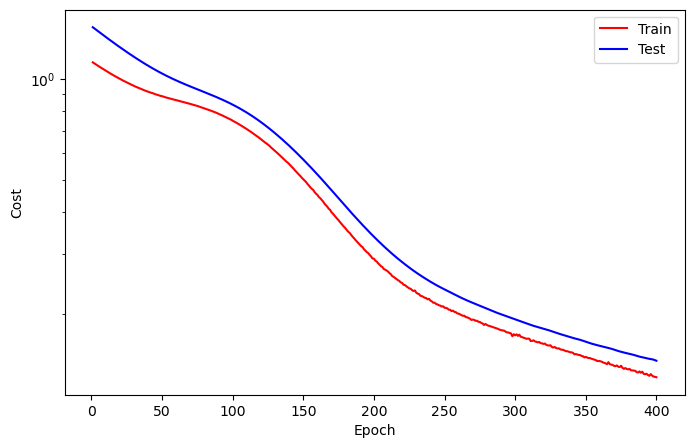

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 0.1289 | Test_cost  = 0.1441 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 0.1290 | Test_cost  = 0.1435 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 0.1283 | Test_cost  = 0.1429 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 0.1283 | Test_cost  = 0.1423 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 0.1274 | Test_cost  = 0.1419 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 0.1276 | Test_cost  = 0.1416 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 0.1278 | Test_cost  = 0.1415 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 0.1253 | Test_cost  = 0.1415 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 0.1269 | Test_cost  = 0.1414 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 0.1262 | Test_cost  = 0.1413 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 0.1259 | Test_cost  = 0.1410 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   412
Train_cost  = 0.1256 | Test_cost  = 0.1405 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   413
Train_cost  = 0.1252 | Test_cost  = 0.1399 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   414
Train_cost  = 0.1249 | Test_cost  = 0.1392 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   415
Train_cost  = 0.1244 | Test_cost  = 0.1386 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   416
Train_cost  = 0.1249 | Test_cost  = 0.1382 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   417
Train_cost  = 0.1238 | Test_cost  = 0.1378 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   418
Train_cost  = 0.1238 | Test_cost  = 0.1375 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   419
Train_cost  = 0.1235 | Test_cost  = 0.1372 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   420
Train_cost  = 0.1233 | Test_cost  = 0.1370 | 


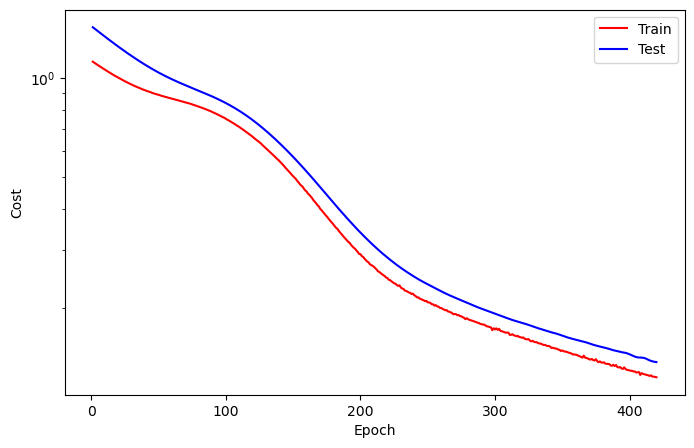

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 0.1232 | Test_cost  = 0.1370 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 0.1230 | Test_cost  = 0.1367 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   423
Train_cost  = 0.1233 | Test_cost  = 0.1363 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   424
Train_cost  = 0.1222 | Test_cost  = 0.1359 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 0.1219 | Test_cost  = 0.1354 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 0.1223 | Test_cost  = 0.1350 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 0.1215 | Test_cost  = 0.1346 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 0.1201 | Test_cost  = 0.1342 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 0.1209 | Test_cost  = 0.1339 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 0.1207 | Test_cost  = 0.1335 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 0.1205 | Test_cost  = 0.1332 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 0.1215 | Test_cost  = 0.1329 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 0.1197 | Test_cost  = 0.1325 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 0.1194 | Test_cost  = 0.1322 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 0.1195 | Test_cost  = 0.1319 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 0.1193 | Test_cost  = 0.1316 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 0.1194 | Test_cost  = 0.1313 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 0.1184 | Test_cost  = 0.1310 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 0.1182 | Test_cost  = 0.1307 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 0.1180 | Test_cost  = 0.1303 | 


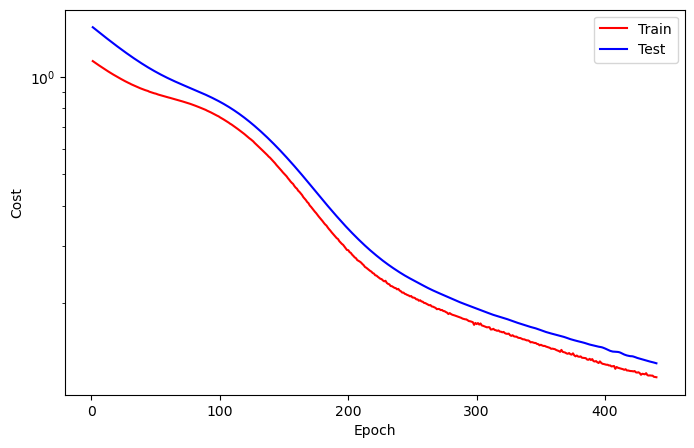

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 0.1183 | Test_cost  = 0.1300 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 0.1186 | Test_cost  = 0.1297 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 0.1183 | Test_cost  = 0.1294 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 0.1183 | Test_cost  = 0.1291 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 0.1176 | Test_cost  = 0.1289 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 0.1173 | Test_cost  = 0.1286 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   447
Train_cost  = 0.1198 | Test_cost  = 0.1285 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   448
Train_cost  = 0.1174 | Test_cost  = 0.1282 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   449
Train_cost  = 0.1167 | Test_cost  = 0.1280 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   450
Train_cost  = 0.1166 | Test_cost  = 0.1276 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   451
Train_cost  = 0.1167 | Test_cost  = 0.1273 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   452
Train_cost  = 0.1159 | Test_cost  = 0.1269 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   453
Train_cost  = 0.1160 | Test_cost  = 0.1265 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   454
Train_cost  = 0.1159 | Test_cost  = 0.1263 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   455
Train_cost  = 0.1154 | Test_cost  = 0.1260 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   456
Train_cost  = 0.1159 | Test_cost  = 0.1258 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   457
Train_cost  = 0.1154 | Test_cost  = 0.1256 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   458
Train_cost  = 0.1152 | Test_cost  = 0.1253 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   459
Train_cost  = 0.1156 | Test_cost  = 0.1251 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   460
Train_cost  = 0.1144 | Test_cost  = 0.1249 | 


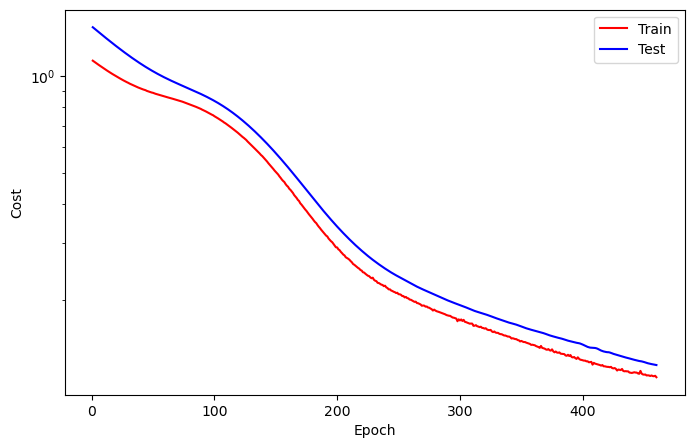

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   461
Train_cost  = 0.1149 | Test_cost  = 0.1247 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   462
Train_cost  = 0.1146 | Test_cost  = 0.1244 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   463
Train_cost  = 0.1145 | Test_cost  = 0.1242 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   464
Train_cost  = 0.1143 | Test_cost  = 0.1239 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   465
Train_cost  = 0.1142 | Test_cost  = 0.1237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   466
Train_cost  = 0.1141 | Test_cost  = 0.1234 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   467
Train_cost  = 0.1140 | Test_cost  = 0.1232 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   468
Train_cost  = 0.1153 | Test_cost  = 0.1231 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   469
Train_cost  = 0.1137 | Test_cost  = 0.1231 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   470
Train_cost  = 0.1143 | Test_cost  = 0.1230 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   471
Train_cost  = 0.1124 | Test_cost  = 0.1229 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   472
Train_cost  = 0.1134 | Test_cost  = 0.1226 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   473
Train_cost  = 0.1132 | Test_cost  = 0.1223 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   474
Train_cost  = 0.1121 | Test_cost  = 0.1220 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   475
Train_cost  = 0.1129 | Test_cost  = 0.1217 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   476
Train_cost  = 0.1154 | Test_cost  = 0.1214 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   477
Train_cost  = 0.1126 | Test_cost  = 0.1212 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   478
Train_cost  = 0.1141 | Test_cost  = 0.1211 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   479
Train_cost  = 0.1124 | Test_cost  = 0.1209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   480
Train_cost  = 0.1123 | Test_cost  = 0.1209 | 


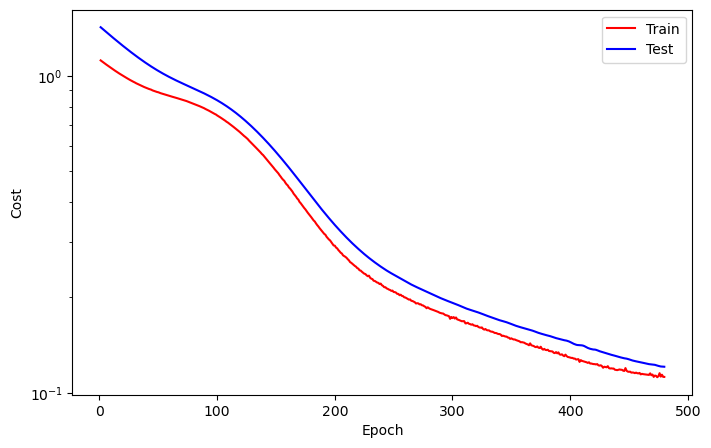

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   481
Train_cost  = 0.1126 | Test_cost  = 0.1209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   482
Train_cost  = 0.1122 | Test_cost  = 0.1207 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   483
Train_cost  = 0.1121 | Test_cost  = 0.1205 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   484
Train_cost  = 0.1130 | Test_cost  = 0.1202 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   485
Train_cost  = 0.1120 | Test_cost  = 0.1199 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   486
Train_cost  = 0.1117 | Test_cost  = 0.1196 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   487
Train_cost  = 0.1116 | Test_cost  = 0.1193 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   488
Train_cost  = 0.1119 | Test_cost  = 0.1191 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   489
Train_cost  = 0.1121 | Test_cost  = 0.1190 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   490
Train_cost  = 0.1114 | Test_cost  = 0.1189 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   491
Train_cost  = 0.1124 | Test_cost  = 0.1190 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1189


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   492
Train_cost  = 0.1111 | Test_cost  = 0.1190 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1189


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   493
Train_cost  = 0.1114 | Test_cost  = 0.1190 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1189


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   494
Train_cost  = 0.1118 | Test_cost  = 0.1189 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1189


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   495
Train_cost  = 0.1117 | Test_cost  = 0.1187 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   496
Train_cost  = 0.1108 | Test_cost  = 0.1185 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   497
Train_cost  = 0.1104 | Test_cost  = 0.1180 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   498
Train_cost  = 0.1115 | Test_cost  = 0.1177 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   499
Train_cost  = 0.1105 | Test_cost  = 0.1175 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   500
Train_cost  = 0.1104 | Test_cost  = 0.1173 | 


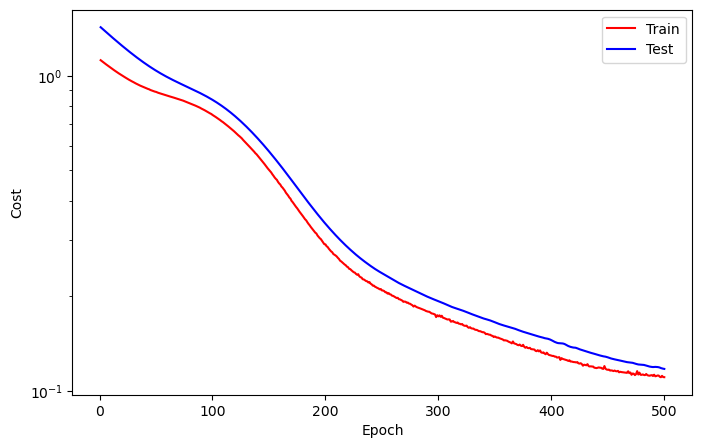

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   501
Train_cost  = 0.1103 | Test_cost  = 0.1172 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   502
Train_cost  = 0.1108 | Test_cost  = 0.1172 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1172


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   503
Train_cost  = 0.1106 | Test_cost  = 0.1173 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1172


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   504
Train_cost  = 0.1104 | Test_cost  = 0.1172 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1172


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   505
Train_cost  = 0.1100 | Test_cost  = 0.1171 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   506
Train_cost  = 0.1105 | Test_cost  = 0.1171 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   507
Train_cost  = 0.1100 | Test_cost  = 0.1170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   508
Train_cost  = 0.1097 | Test_cost  = 0.1168 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   509
Train_cost  = 0.1097 | Test_cost  = 0.1166 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   510
Train_cost  = 0.1113 | Test_cost  = 0.1164 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   511
Train_cost  = 0.1097 | Test_cost  = 0.1161 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   512
Train_cost  = 0.1087 | Test_cost  = 0.1159 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   513
Train_cost  = 0.1097 | Test_cost  = 0.1160 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1159


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   514
Train_cost  = 0.1086 | Test_cost  = 0.1161 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1159


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   515
Train_cost  = 0.1091 | Test_cost  = 0.1161 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1159


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   516
Train_cost  = 0.1088 | Test_cost  = 0.1160 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1159


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   517
Train_cost  = 0.1085 | Test_cost  = 0.1159 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   518
Train_cost  = 0.1087 | Test_cost  = 0.1157 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   519
Train_cost  = 0.1091 | Test_cost  = 0.1154 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   520
Train_cost  = 0.1088 | Test_cost  = 0.1152 | 


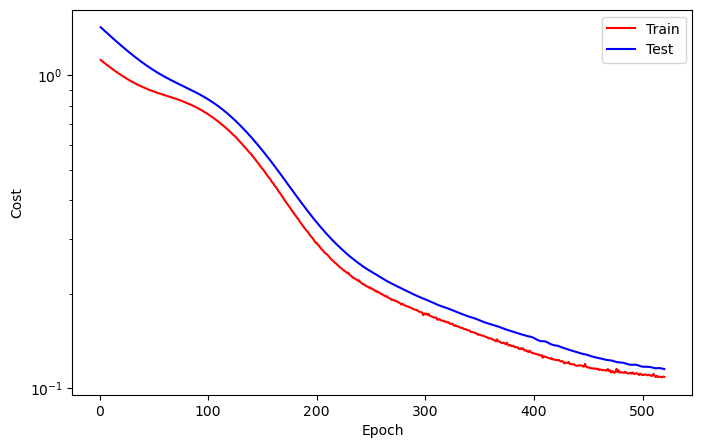

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   521
Train_cost  = 0.1088 | Test_cost  = 0.1151 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   522
Train_cost  = 0.1087 | Test_cost  = 0.1150 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   523
Train_cost  = 0.1083 | Test_cost  = 0.1150 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   524
Train_cost  = 0.1093 | Test_cost  = 0.1151 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1150


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   525
Train_cost  = 0.1095 | Test_cost  = 0.1148 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   526
Train_cost  = 0.1101 | Test_cost  = 0.1151 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1148


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   527
Train_cost  = 0.1082 | Test_cost  = 0.1153 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1148


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   528
Train_cost  = 0.1076 | Test_cost  = 0.1152 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1148


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   529
Train_cost  = 0.1081 | Test_cost  = 0.1149 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1148


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   530
Train_cost  = 0.1080 | Test_cost  = 0.1145 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   531
Train_cost  = 0.1082 | Test_cost  = 0.1140 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   532
Train_cost  = 0.1075 | Test_cost  = 0.1136 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   533
Train_cost  = 0.1077 | Test_cost  = 0.1134 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   534
Train_cost  = 0.1076 | Test_cost  = 0.1133 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   535
Train_cost  = 0.1077 | Test_cost  = 0.1134 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1133


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   536
Train_cost  = 0.1093 | Test_cost  = 0.1137 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1133


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   537
Train_cost  = 0.1073 | Test_cost  = 0.1142 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1133


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   538
Train_cost  = 0.1073 | Test_cost  = 0.1144 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1133


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   539
Train_cost  = 0.1073 | Test_cost  = 0.1145 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1133
==> Execute Early Stopping at epoch: 539 | Best test_cost: 0.1133
==> Best model is saved at model/gru


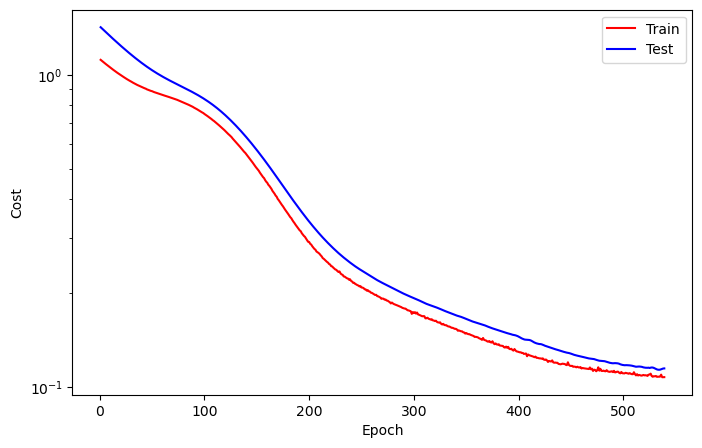

In [34]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [35]:
train_forecast_set = TimeSeriesDataset(ts_train, "united_states_all_sectors", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "united_states_all_sectors", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (203, 1, 1)
Note: last 0 data excluded

(N, S, F): (50, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

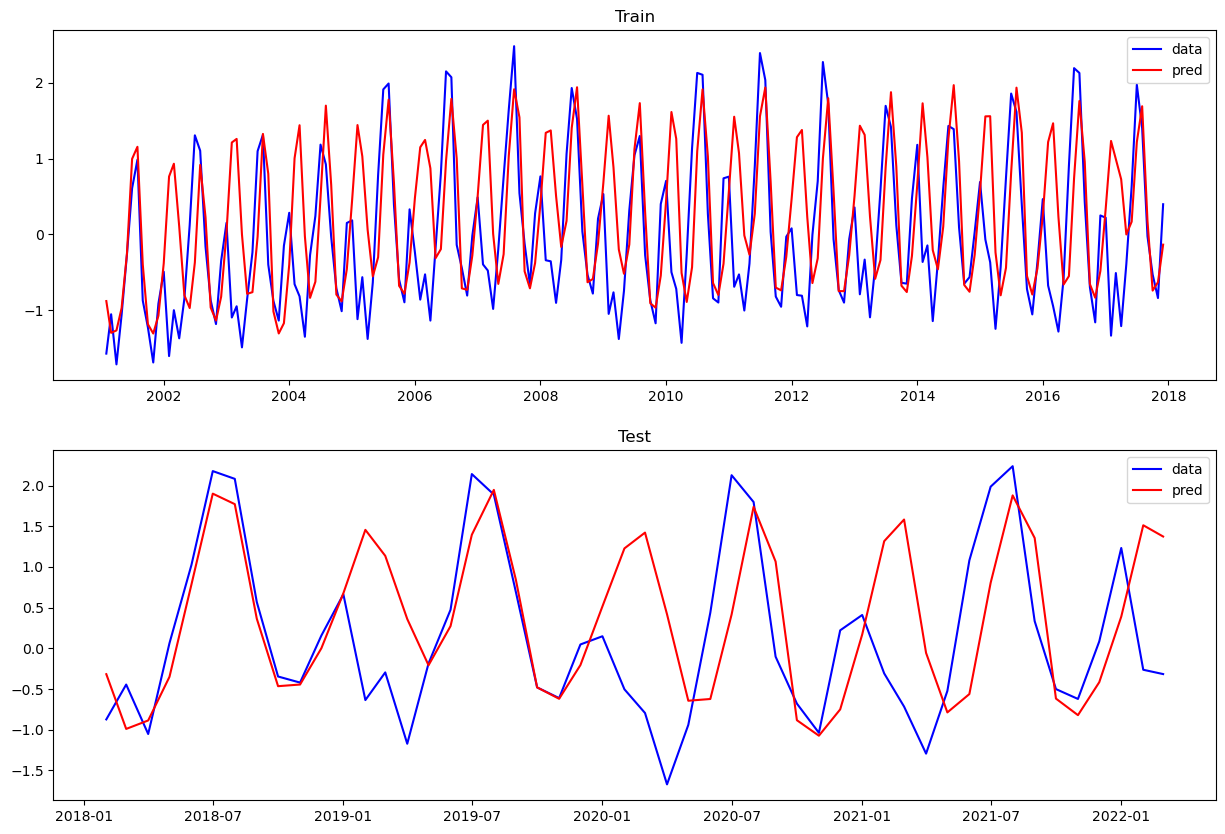

In [36]:
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

IndexError: index 75 is out of bounds for axis 0 with size 50

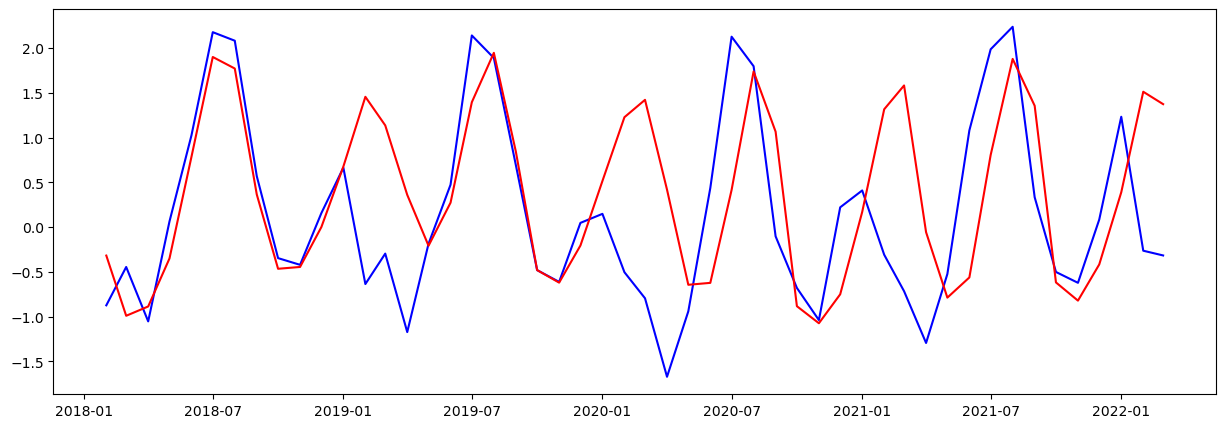

In [37]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')